In [ ]:
#### JBL

In [ ]:
# Hybrid Model Analysis for RF and FSO Attenuation
# Hybrid Method 1 (M1) is Using predicted RF Att to forecast FSO Att
# Hybrid Method 2 (M2) is Using predicted FSO Att to predict RF Att

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_csv("RFLFSODataFull.csv")

ORI_X_train, ORI_X_val, RF_Y_train, RF_Y_val = train_test_split(data, data["RFL_Att"], test_size=0.2, random_state=42)

RF_X_train = ORI_X_train.drop(columns=["RFL_Att", "FSO_Att"])
RF_X_val = ORI_X_val.drop(columns=["RFL_Att", "FSO_Att"])

store_ori_RF_FSO = pd.DataFrame({'RF_ORI': RF_Y_train, 'FSO_ORI': ORI_X_train["FSO_Att"]})
store_ori_test_RF_FSO = pd.DataFrame({'RF_ORI': RF_Y_val, 'FSO_ORI': ORI_X_val["FSO_Att"]})

param_grid = {
    'n_estimators': range(100,150,10),
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# uzing hhybrid Method 1 (M1) use predicted RF to predict FSO
# RF model
RF_model = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)
RF_grid_search = GridSearchCV(RF_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
RF_grid_search.fit(RF_X_train, RF_Y_train)
print("Best parameters for RF (Method 1):", RF_grid_search.best_params_)

best_RF_Model = RF_grid_search.best_estimator_

RF_pred_y_train_M1 = best_RF_Model.predict(RF_X_train)
RF_pred_y_test_M1 = best_RF_Model.predict(RF_X_val)

FSO_X_train_M1 = RF_X_train.copy()
FSO_X_train_M1['RFL_Att_pred'] = RF_pred_y_train_M1
FSO_X_val_M1 = RF_X_val.copy()
FSO_X_val_M1['RFL_Att_pred'] = RF_pred_y_test_M1

# FSO model
FSO_model = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)
FSO_grid_search_M1 = GridSearchCV(FSO_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
FSO_grid_search_M1.fit(FSO_X_train_M1, store_ori_RF_FSO["FSO_ORI"])
print("Best parameters for FSO (Method 1):", FSO_grid_search_M1.best_params_)

FSO_M1_best_model = FSO_grid_search_M1.best_estimator_

M1_FSO_Y_train_PRED = FSO_M1_best_model.predict(FSO_X_train_M1)
M1_FSO_Y_test_PRED = FSO_M1_best_model.predict(FSO_X_val_M1)

#  uzingg hybrid Method 2 (M2) use predicted FSO to predict RF

FSO_X_train = ORI_X_train.drop(columns=["RFL_Att", "FSO_Att"])
FSO_X_val = ORI_X_val.drop(columns=["RFL_Att", "FSO_Att"])

FSO_grid_search_M2 = GridSearchCV(FSO_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
FSO_grid_search_M2.fit(FSO_X_train, store_ori_RF_FSO["FSO_ORI"])
print("Best parameters for FSO (Method 2):", FSO_grid_search_M2.best_params_)

FSO_M2_best_model = FSO_grid_search_M2.best_estimator_

M2_FSO_PRED_Y_train = FSO_M2_best_model.predict(FSO_X_train)
M2_FSO_PRED_Y_test = FSO_M2_best_model.predict(FSO_X_val)

RF_M2_X_train = FSO_X_train.copy()
RF_M2_X_train['FSO_Att_pred'] = M2_FSO_PRED_Y_train
RF_M2_X_val = FSO_X_val.copy()
RF_M2_X_val['FSO_Att_pred'] = M2_FSO_PRED_Y_test

#  RF model
RF_grid_search_M2 = GridSearchCV(RF_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
RF_grid_search_M2.fit(RF_M2_X_train, RF_Y_train)
print("Best parameters for RFL (Method 2):", RF_grid_search_M2.best_params_)

M2_BEST_RF_MODEL = RF_grid_search_M2.best_estimator_

M2_RF_PRED_Y_train = M2_BEST_RF_MODEL.predict(RF_M2_X_train)
M2_RF_PRED_Y_test = M2_BEST_RF_MODEL.predict(RF_M2_X_val)

# Evaluation for M 1
M1_FSO_TRAIN_RMSE = np.sqrt(mean_squared_error(store_ori_RF_FSO["FSO_ORI"], M1_FSO_Y_train_PRED))
M1_FSO_TEST_RMSE = np.sqrt(mean_squared_error(store_ori_test_RF_FSO["FSO_ORI"], M1_FSO_Y_test_PRED))
M1_FSO_TRAIN_R2 = r2_score(store_ori_RF_FSO["FSO_ORI"], M1_FSO_Y_train_PRED)
M1_FSO_TEST_R2 = r2_score(store_ori_test_RF_FSO["FSO_ORI"], M1_FSO_Y_test_PRED)

print("Method 1 - FSO Train RMSE:", M1_FSO_TRAIN_RMSE, "Test RMSE:", M1_FSO_TEST_RMSE, "Train R2:", M1_FSO_TRAIN_R2, "Test R2:", M1_FSO_TEST_R2)

# Evaluation for M 2
M2_TRAIN_RMSE = np.sqrt(mean_squared_error(RF_Y_train, M2_RF_PRED_Y_train))
M2_TEST_RMSE = np.sqrt(mean_squared_error(RF_Y_val, M2_RF_PRED_Y_test))
M2_TRAIN_R2 = r2_score(RF_Y_train, M2_RF_PRED_Y_train)
M2_TEST_R2 = r2_score(RF_Y_val, M2_RF_PRED_Y_test)

print("Method 2 - Train RMSE:", M2_TRAIN_RMSE, "Test RMSE:", M2_TEST_RMSE, "Train R2:", M2_TRAIN_R2, "Test R2:", M2_TEST_R2)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for RF (Method 1): {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 140}


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for FSO (Method 1): {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 140}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for FSO (Method 2): {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 140}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for RFL (Method 2): {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 140}
Method 1 - FSO Train RMSE: 0.3245832725537094 Test RMSE: 0.8769308849973587 Train R2: 0.9930827909505008 Test R2: 0.9496590790187162
Method 2 - Train RMSE: 0.20371817034490633 Test RMSE: 0.6123803841333267 Train R2: 0.9964748621246466 Test R2: 0.9688451967259958


In [ ]:
print("Best parameters for RF (Method 1):", RF_grid_search.best_params_)
print("Best parameters for FSO (Method 1):", FSO_grid_search_M1.best_params_)

print("Best parameters for FSO (Method 2):", FSO_grid_search_M2.best_params_)
print("Best parameters for RF (Method 2):", RF_grid_search_M2.best_params_)


Best parameters for RF (Method 1): {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 140}
Best parameters for FSO (Method 1): {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 140}
Best parameters for FSO (Method 2): {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 140}
Best parameters for RF (Method 2): {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 140}


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_csv("RFLFSODataFull.csv")

ORI_X_TRAIN, ORI_X_TEMP, RF_Y_TRAIN, RF_Y_TEMP = train_test_split(data, data["RFL_Att"], test_size=0.2, random_state=42)
ORI_X_VAL, ORI_X_TEST, RF_Y_VAL, RF_Y_TEST = train_test_split(ORI_X_TEMP, RF_Y_TEMP, test_size=0.5, random_state=42)

STORE_train_RF_FSO = pd.DataFrame({'ORI_RF': RF_Y_TRAIN, 'ORI_FSO': ORI_X_TRAIN["FSO_Att"]})
STORE_val_RF_FSO = pd.DataFrame({'ORI_RF': RF_Y_VAL, 'ORI_FSO': ORI_X_VAL["FSO_Att"]})
STORE_test_RF_FSO = pd.DataFrame({'ORI_RF': RF_Y_TEST, 'ORI_FSO': ORI_X_TEST["FSO_Att"]})

X_TRAIN = ORI_X_TRAIN.drop(columns=["RFL_Att", "FSO_Att"])
X_VAL = ORI_X_VAL.drop(columns=["RFL_Att", "FSO_Att"])
X_TEST = ORI_X_TEST.drop(columns=["RFL_Att", "FSO_Att"])

best_PARAMS = {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 140}

#  uzing hybrid Method 1 (M1) use predicted RF to predict FSO
# ttrain RF model
BEST_RF_MODEL_M1 = RandomForestRegressor(**best_PARAMS, random_state=42, oob_score=True, n_jobs=-1)
BEST_RF_MODEL_M1.fit(X_TRAIN, RF_Y_TRAIN)

RF_pred_y_train_M1 = BEST_RF_MODEL_M1.predict(X_TRAIN)
RF_pred_y_val_M1 = BEST_RF_MODEL_M1.predict(X_VAL)
RF_pred_y_test_M1 = BEST_RF_MODEL_M1.predict(X_TEST)

FSO_X_train_M1 = X_TRAIN.copy()
FSO_X_train_M1['RFL_Att_pred'] = RF_pred_y_train_M1
FSO_X_val_M1 = X_VAL.copy()
FSO_X_val_M1['RFL_Att_pred'] = RF_pred_y_val_M1
Xtest_fso_m1 = X_TEST.copy()
Xtest_fso_m1['RFL_Att_pred'] = RF_pred_y_test_M1

# train FSO model
FSO_M1_best_model = RandomForestRegressor(**best_PARAMS, random_state=42, oob_score=True, n_jobs=-1)
FSO_M1_best_model.fit(FSO_X_train_M1, STORE_train_RF_FSO["ORI_FSO"])

M1_FSO_Y_train_PRED = FSO_M1_best_model.predict(FSO_X_train_M1)
M1_FSO_Y_val_PRED= FSO_M1_best_model.predict(FSO_X_val_M1)
M1_FSO_Y_test_PRED = FSO_M1_best_model.predict(Xtest_fso_m1)

#  uzing hybrid Method 2 (M2) use predicted FSO to predict RF
FSO_X_train = ORI_X_TRAIN.drop(columns=["RFL_Att", "FSO_Att"])
FSO_X_val = ORI_X_VAL.drop(columns=["RFL_Att", "FSO_Att"])
FSO_X_test = ORI_X_TEST.drop(columns=["RFL_Att", "FSO_Att"])

# training FSO model
FSO_M2_best_model = RandomForestRegressor(**best_PARAMS, random_state=42, oob_score=True, n_jobs=-1)
FSO_M2_best_model.fit(FSO_X_train, STORE_train_RF_FSO["ORI_FSO"])

M2_FSO_PRED_Y_train = FSO_M2_best_model.predict(FSO_X_train)
M2_FSO_PRED_Y_val = FSO_M2_best_model.predict(FSO_X_val)
M2_FSO_PRED_Y_test = FSO_M2_best_model.predict(FSO_X_test)

RF_M2_X_train = FSO_X_train.copy()
RF_M2_X_train['FSO_Att_pred'] = M2_FSO_PRED_Y_train
RF_M2_X_val = FSO_X_val.copy()
RF_M2_X_val['FSO_Att_pred'] = M2_FSO_PRED_Y_val
RF_M2_X_test = FSO_X_test.copy()
RF_M2_X_test['FSO_Att_pred'] = M2_FSO_PRED_Y_test

# trainingg RF model
BEST_RF_MODEL_M2 = RandomForestRegressor(**best_PARAMS, random_state=42, oob_score=True, n_jobs=-1)
BEST_RF_MODEL_M2.fit(RF_M2_X_train, RF_Y_TRAIN)

M2_RF_PRED_Y_train = BEST_RF_MODEL_M2.predict(RF_M2_X_train)
M2_RF_PRED_Y_val = BEST_RF_MODEL_M2.predict(RF_M2_X_val)
M2_RF_PRED_Y_test = BEST_RF_MODEL_M2.predict(RF_M2_X_test)

#  evaluation mmetrics
def evaluate_model(Y_TRUE_TRAIN, Y_PRED_TRAIN, Y_TRUE_VAL, Y_PRED_VAL, Y_TRUE_TEST, Y_PRED_TEST, method):
    RMSE_TRAIN = np.sqrt(mean_squared_error(Y_TRUE_TRAIN, Y_PRED_TRAIN))
    RMSE_VAL = np.sqrt(mean_squared_error(Y_TRUE_VAL, Y_PRED_VAL))
    RMSE_TEST = np.sqrt(mean_squared_error(Y_TRUE_TEST, Y_PRED_TEST))

    R2_TRAIN = r2_score(Y_TRUE_TRAIN, Y_PRED_TRAIN)
    R2_VAL = r2_score(Y_TRUE_VAL, Y_PRED_VAL)
    R2_TEST= r2_score(Y_TRUE_TEST, Y_PRED_TEST)

    print(f"{method} - Train RMSE: {RMSE_TRAIN:.4f}, Validation RMSE: {RMSE_VAL:.4f}, Test RMSE: {RMSE_TEST:.4f}")
    print(f"{method} - Train R2: {R2_TRAIN:.4f}, Validation R2: {R2_VAL:.4f}, Test R2: {R2_TEST:.4f}")

# evaluate M 1 and m 2
evaluate_model(STORE_train_RF_FSO["ORI_FSO"], M1_FSO_Y_train_PRED, STORE_val_RF_FSO["ORI_FSO"], M1_FSO_Y_val_PRED, STORE_test_RF_FSO["ORI_FSO"], M1_FSO_Y_test_PRED, "Method 1 (FSO) Hybrid Method 1 ")

evaluate_model(RF_Y_TRAIN, M2_RF_PRED_Y_train, RF_Y_VAL, M2_RF_PRED_Y_val, RF_Y_TEST, M2_RF_PRED_Y_test, "Method 2 (RF) Hybrid Method 2")


Method 1 (FSO) Hybrid Method 1  - Train RMSE: 0.3246, Validation RMSE: 0.8753, Test RMSE: 0.8786
Method 1 (FSO) Hybrid Method 1  - Train R2: 0.9931, Validation R2: 0.9507, Test R2: 0.9486
Method 2 (RF) Hybrid Method 2 - Train RMSE: 0.2037, Validation RMSE: 0.6499, Test RMSE: 0.5724
Method 2 (RF) Hybrid Method 2 - Train R2: 0.9965, Validation R2: 0.9652, Test R2: 0.9725


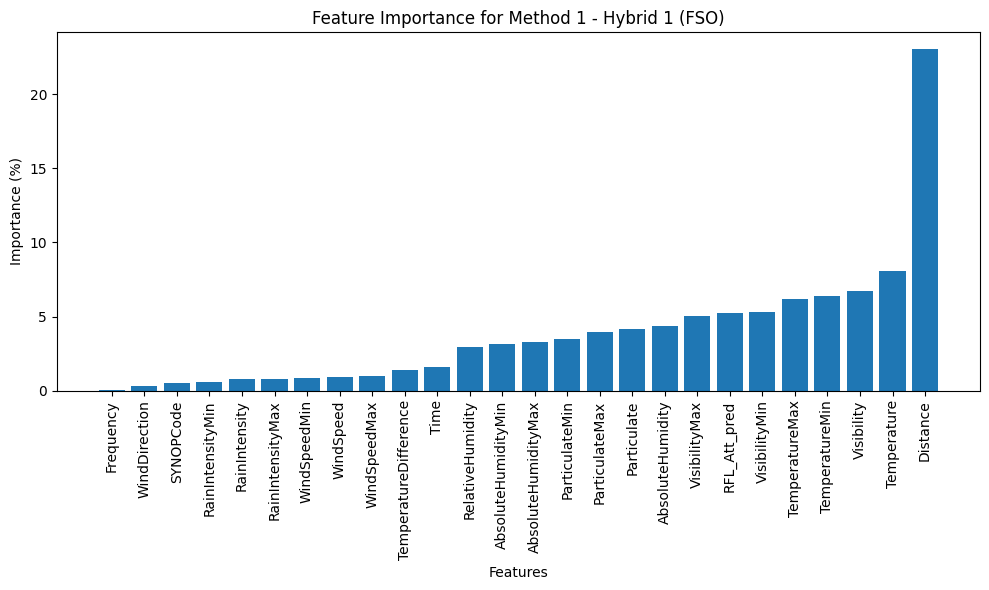

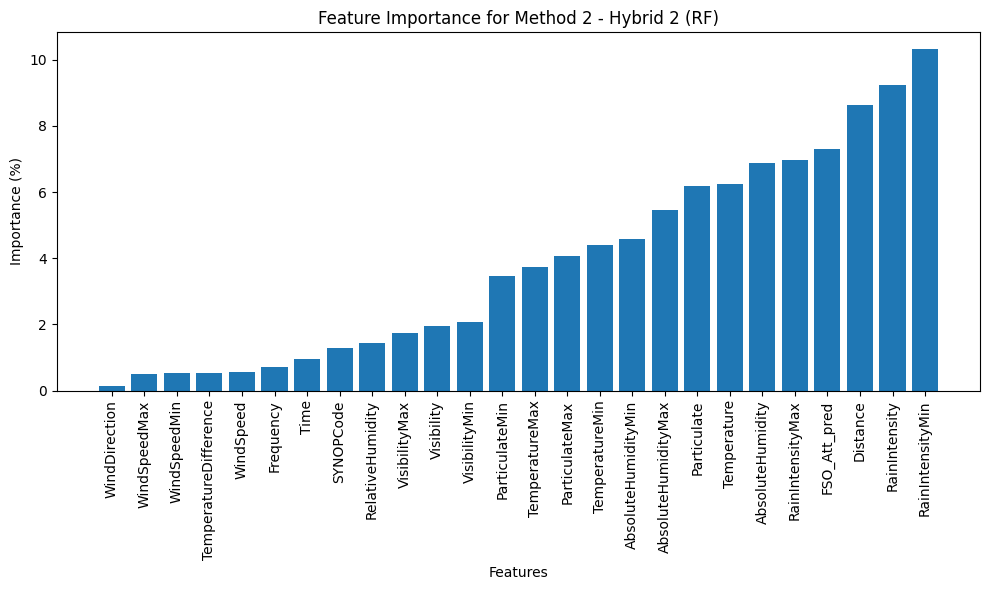

Top 10 Features for Method 1 (FSO):
Distance: 23.03%
Temperature: 8.04%
Visibility: 6.69%
TemperatureMin: 6.39%
TemperatureMax: 6.16%
VisibilityMin: 5.29%
RFL_Att_pred: 5.25%
VisibilityMax: 5.04%
AbsoluteHumidity: 4.37%
Particulate: 4.16%

Top 10 Features for Method 2 (RF):
RainIntensityMin: 10.31%
RainIntensity: 9.23%
Distance: 8.65%
FSO_Att_pred: 7.29%
RainIntensityMax: 6.97%
AbsoluteHumidity: 6.87%
Temperature: 6.26%
Particulate: 6.17%
AbsoluteHumidityMax: 5.47%
AbsoluteHumidityMin: 4.60%


In [ ]:
def plotting_feature_importance(model, features, title):
    model_important = model.feature_importances_
    sorted = np.argsort(model_important)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted)), model_important[sorted] * 100, align='center')
    plt.xticks(range(len(sorted)), [features[i] for i in sorted], rotation=90)
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance (%)")
    plt.tight_layout()
    plt.show()


plotting_feature_importance(FSO_M1_best_model, FSO_X_train_M1.columns, "Feature Importance for Method 1 - Hybrid 1 (FSO)")
plotting_feature_importance(BEST_RF_MODEL_M2, RF_M2_X_train.columns, "Feature Importance for Method 2 - Hybrid 2 (RF)")

# displaying
# 10 Features M 1 for FSO
importance_m1 = FSO_M1_best_model.feature_importances_
feature_names_m1 = FSO_X_train_M1.columns
top_10_M1 = np.argsort(importance_m1)[-10:][::-1]
print("Top 10 Features for Method 1 (FSO):")
for i in top_10_M1:
    print(f"{feature_names_m1[i]}: {importance_m1[i] * 100:.2f}%")

# 10 Features M 2 for RF
importance_m2 = BEST_RF_MODEL_M2.feature_importances_
feature_names_m2 = RF_M2_X_train.columns
top_10_M2 = np.argsort(importance_m2)[-10:][::-1]
print("\nTop 10 Features for Method 2 (RF):")
for i in top_10_M2:
    print(f"{feature_names_m2[i]}: {importance_m2[i] * 100:.2f}%")


In [ ]:
# ssummarizing Predictions for Method 1
# RF to FSO

M1_train_RF_TO_FSO_summary = STORE_train_RF_FSO.copy()
M1_train_RF_TO_FSO_summary["RF_1st"] = RF_pred_y_train_M1
M1_train_RF_TO_FSO_summary["FSO_2nd"] = M1_FSO_Y_train_PRED

M1_test_RF_TO_FSO_summary = STORE_test_RF_FSO.copy()
M1_test_RF_TO_FSO_summary["RF_1st"] = RF_pred_y_test_M1
M1_test_RF_TO_FSO_summary["FSO_2nd"] = M1_FSO_Y_test_PRED


#  ssummarizing Predictions for Method 2
#  FSO to  RF

M2_train_FSO_TO_RF_summary = STORE_train_RF_FSO.copy()
M2_train_FSO_TO_RF_summary["FSO_1st"] = M2_FSO_PRED_Y_train
M2_train_FSO_TO_RF_summary["RF_2nd"] = M2_RF_PRED_Y_train

M2_test_FSO_TO_RF_summary = STORE_test_RF_FSO.copy()
M2_test_FSO_TO_RF_summary["FSO_1st"] = M2_FSO_PRED_Y_test
M2_test_FSO_TO_RF_summary["RF_2nd"] = M2_RF_PRED_Y_test



In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mutual_info_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import normalized_mutual_info_score


store_RF_FSO_train = STORE_train_RF_FSO.copy()
store_RF_FSO_train['RF_1st'] = RF_pred_y_train_M1  # ppredic RF in M 1
store_RF_FSO_train['FSO_2nd'] = M1_FSO_Y_train_PRED  # ppredic FSO in M 1
store_RF_FSO_train['RF_2nd'] = M2_RF_PRED_Y_train  # predic RF in M 2
store_RF_FSO_train['FSO_1st'] = M2_FSO_PRED_Y_train  # predic FSO in M 2

# ooverall correlations
ORI_CORR_RF_FSO, ORI_P_VAL_RF_FSO= pearsonr(store_RF_FSO_train["ORI_RF"], store_RF_FSO_train["ORI_FSO"])
CORR_RF_TO_FSO, P_VAL_RF_TO_FSO = pearsonr(store_RF_FSO_train["RF_1st"], store_RF_FSO_train["FSO_2nd"])
CORR_FSO_TO_RF, P_VAL_FSO_TO_RF = pearsonr(store_RF_FSO_train["RF_2nd"], store_RF_FSO_train["FSO_1st"])

print("Overall Pearson Correlation Coefficients:")
print("Original RF vs Original FSO:", ORI_CORR_RF_FSO, "| p-value:", ORI_P_VAL_RF_FSO)
print("Predicted RF (M1) vs Predicted FSO (M1):", CORR_RF_TO_FSO, "| p-value:", P_VAL_RF_TO_FSO)
print("Predicted RF (M2) vs Predicted FSO (M2):", CORR_FSO_TO_RF, "| p-value:", P_VAL_FSO_TO_RF)

# SYNOP Code Grouping // Pearson correlation for EACHH SYNOP code group
synop_grouped = data.groupby('SYNOPCode')
SYNOP_based_indices = {}

for synop_code, group in synop_grouped:
    index_list = group.index.tolist()
    SYNOP_based_indices[synop_code] = index_list

print(SYNOP_based_indices)


synopcode = [synop_code for i in store_RF_FSO_train.index for synop_code, index_list in SYNOP_based_indices.items() if i in index_list]
store_RF_FSO_train["SYNOPCode"] = synopcode

print("\nPearson Correlation per SYNOP code:")
SYNOP_collated = store_RF_FSO_train.groupby('SYNOPCode')
for n, g in SYNOP_collated:
    ORI_CORR_RF_FSO, value_p_ori = pearsonr(g["ORI_RF"], g["ORI_FSO"])
    CORR_RF_TO_FSO, value_p_RF_TO_FSO = pearsonr(g["RF_1st"], g["FSO_2nd"])
    CORR_FSO_TO_RF, value_P_FSO_TO_RF = pearsonr(g["RF_2nd"], g["FSO_1st"])
    print(f"SYNOPCode={n}: Original vs FSO = {ORI_CORR_RF_FSO}, Method 1 = {CORR_RF_TO_FSO}, Method 2 = {CORR_FSO_TO_RF}")


Overall Pearson Correlation Coefficients:
Original RF vs Original FSO: 0.09100348124104252 | p-value: 3.182943688267995e-134
Predicted RF (M1) vs Predicted FSO (M1): 0.09149847902525923 | p-value: 1.1335542109894612e-135
Predicted RF (M2) vs Predicted FSO (M2): 0.09095810939924025 | p-value: 4.317085989927248e-134
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 53, 57, 63, 69, 70, 71, 72, 73, 74, 75, 88, 89, 90, 91, 99, 100, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 179, 183, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 212, 213, 214, 215, 216,

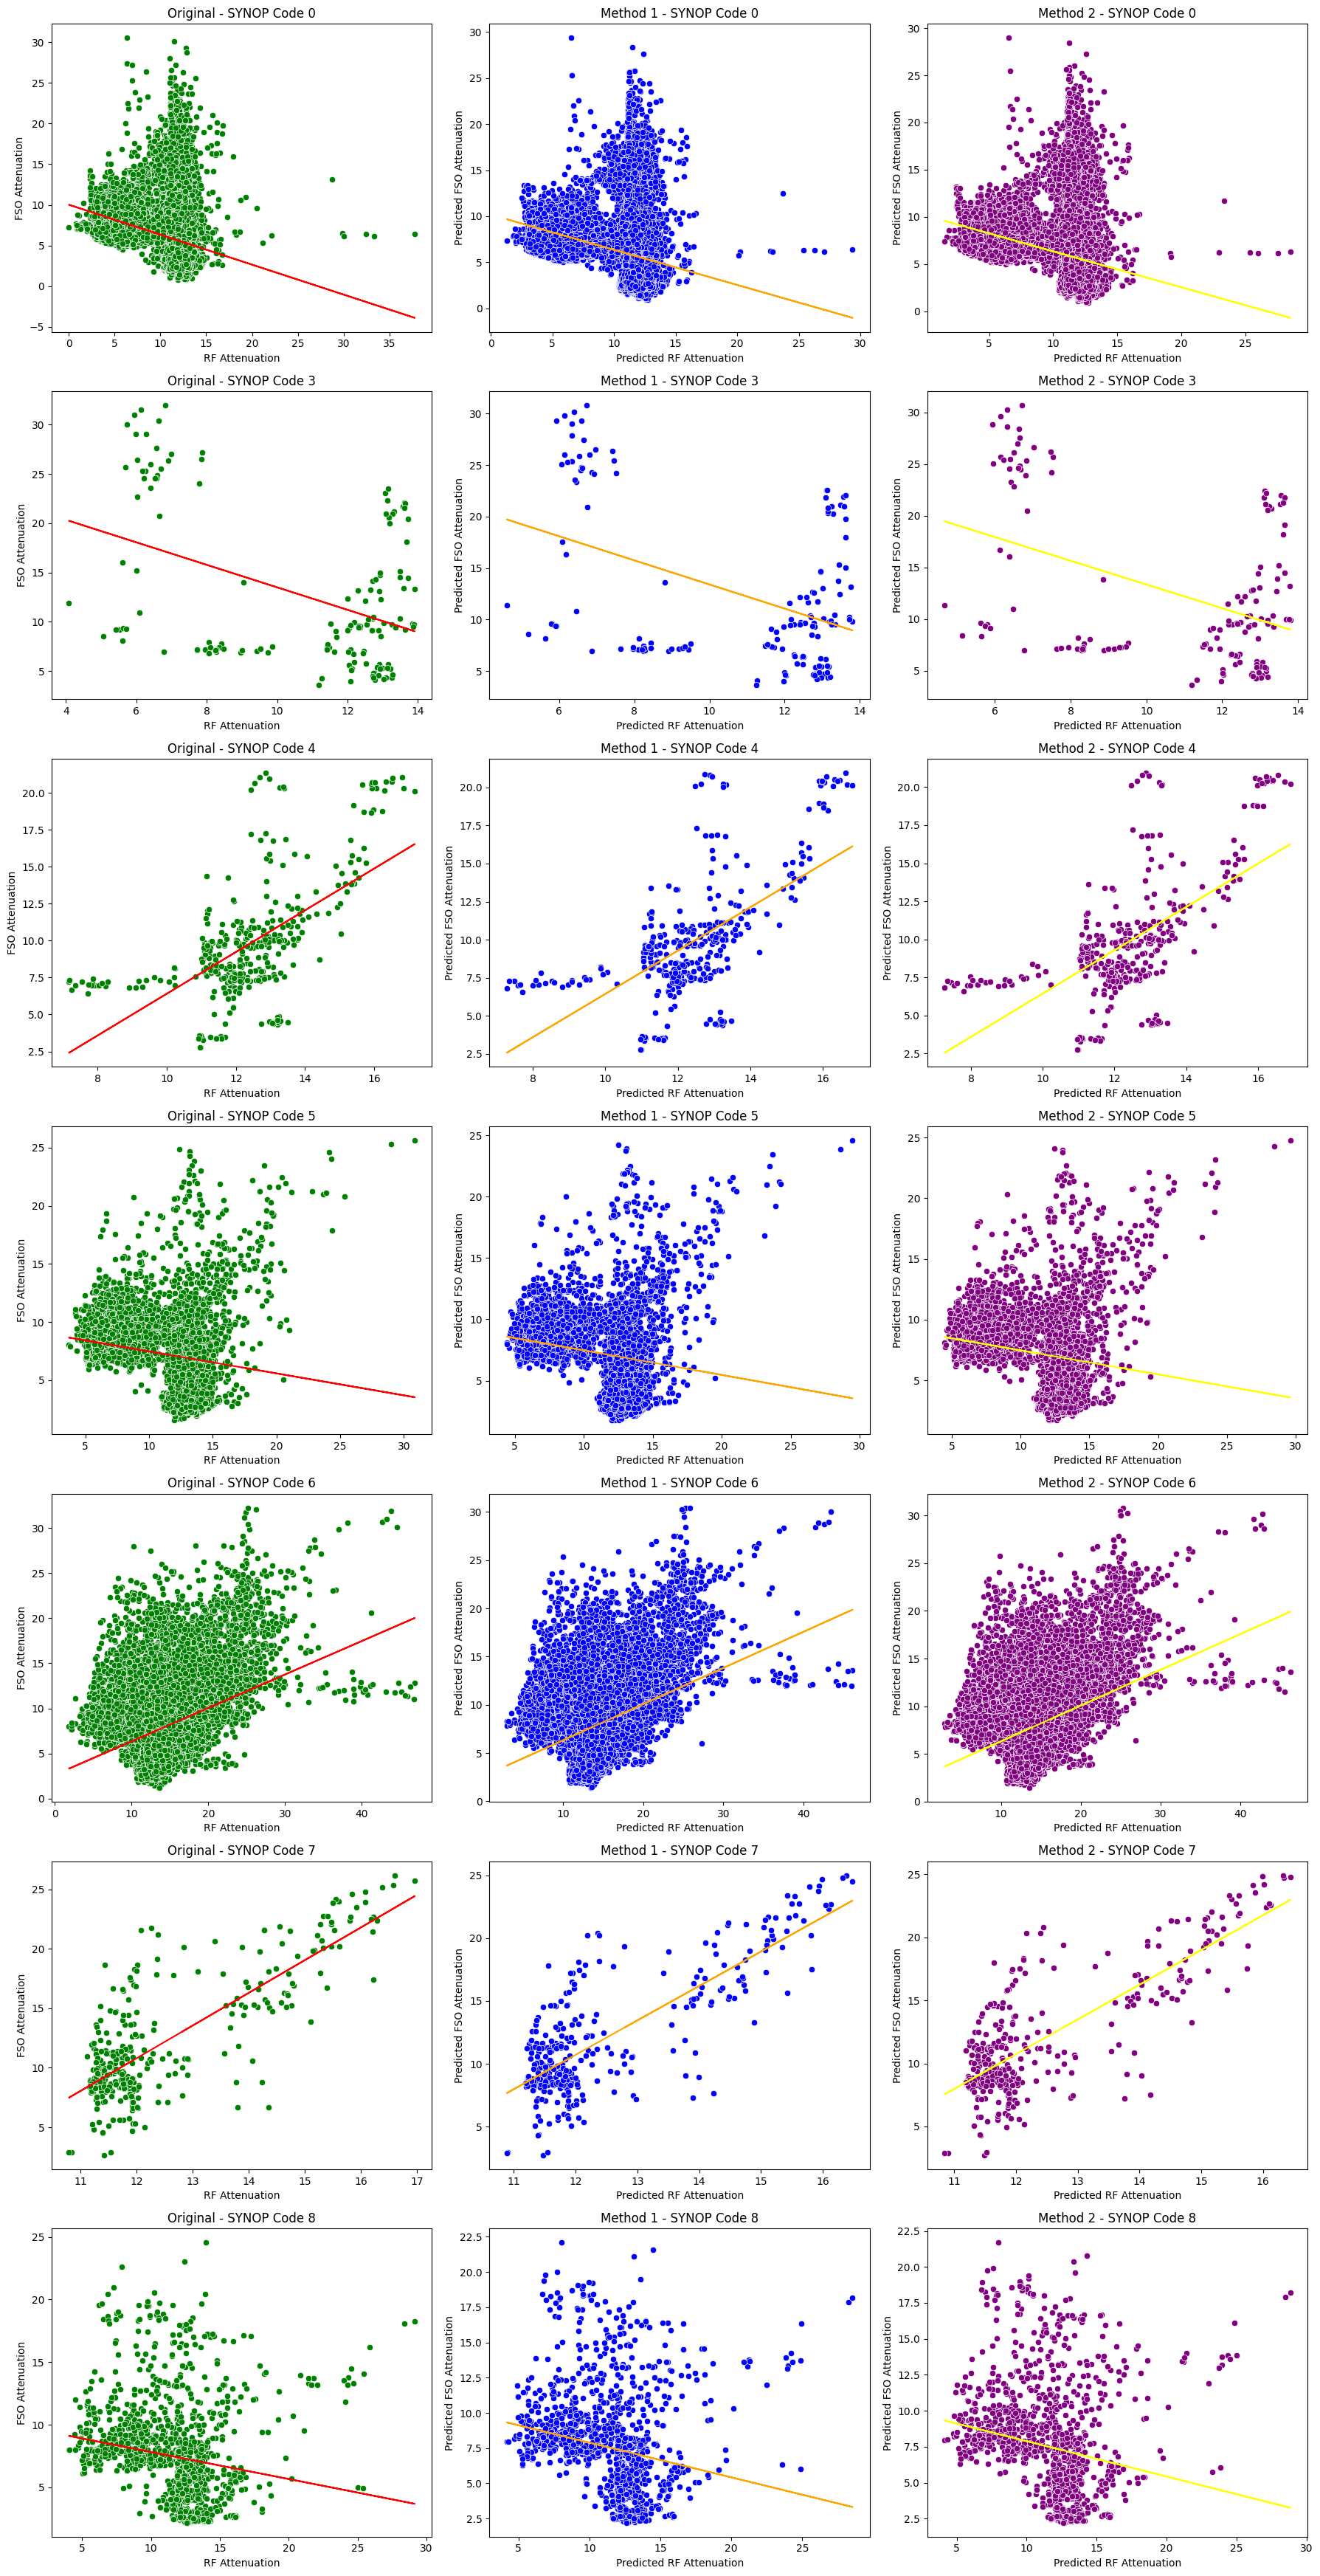

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mutual_info_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import normalized_mutual_info_score
import math

# calculating pearson correlations and plotingg each SYNOP code with three subplots
unique_SYNOP_CODE = store_RF_FSO_train["SYNOPCode"].unique()
NO_plots = len(unique_SYNOP_CODE)
TOTAL_plots = NO_plots * 3  
GRID_cols = 3
GRID_rows = int(np.ceil(TOTAL_plots / GRID_cols))

plt.figure(figsize=(18, GRID_rows * 5))
plot_count = 1

for n, g in SYNOP_collated:
    # plotting original RF vs original FSO
    plt.subplot(GRID_rows, GRID_cols, plot_count)
    sns.scatterplot(x=g['ORI_RF'], y=g['ORI_FSO'], color='green')
    slope, intercept = np.polyfit(g['ORI_RF'], g['ORI_FSO'], 1)
    plt.plot(g['ORI_RF'], slope * g['ORI_RF'] + intercept, color='red')
    plt.title(f'Original - SYNOP Code {n}')
    plt.xlabel('RF Attenuation')
    plt.ylabel('FSO Attenuation')
    plot_count = plot_count + 1

    # plotting predicted RF vs predicted FSO for m 1
    plt.subplot(GRID_rows, GRID_cols, plot_count)
    sns.scatterplot(x=g['RF_1st'], y=g['FSO_2nd'], color='blue')
    slope, intercept = np.polyfit(g['RF_1st'], g['FSO_2nd'], 1)
    plt.plot(g['RF_1st'], slope * g['RF_1st'] + intercept, color='orange')
    plt.title(f'Method 1 - SYNOP Code {n}')
    plt.xlabel('Predicted RF Attenuation')
    plt.ylabel('Predicted FSO Attenuation')
    plot_count = plot_count + 1

    # plotting predicted RF vs predicted FSO for m 2
    plt.subplot(GRID_rows, GRID_cols, plot_count)
    sns.scatterplot(x=g['RF_2nd'], y=g['FSO_1st'], color='purple')
    slope, intercept = np.polyfit(g['RF_2nd'], g['FSO_1st'], 1)
    plt.plot(g['RF_2nd'], slope * g['RF_2nd'] + intercept, color='yellow')
    plt.title(f'Method 2 - SYNOP Code {n}')
    plt.xlabel('Predicted RF Attenuation')
    plt.ylabel('Predicted FSO Attenuation')
    plot_count = plot_count + 1

plt.tight_layout()
plt.show()


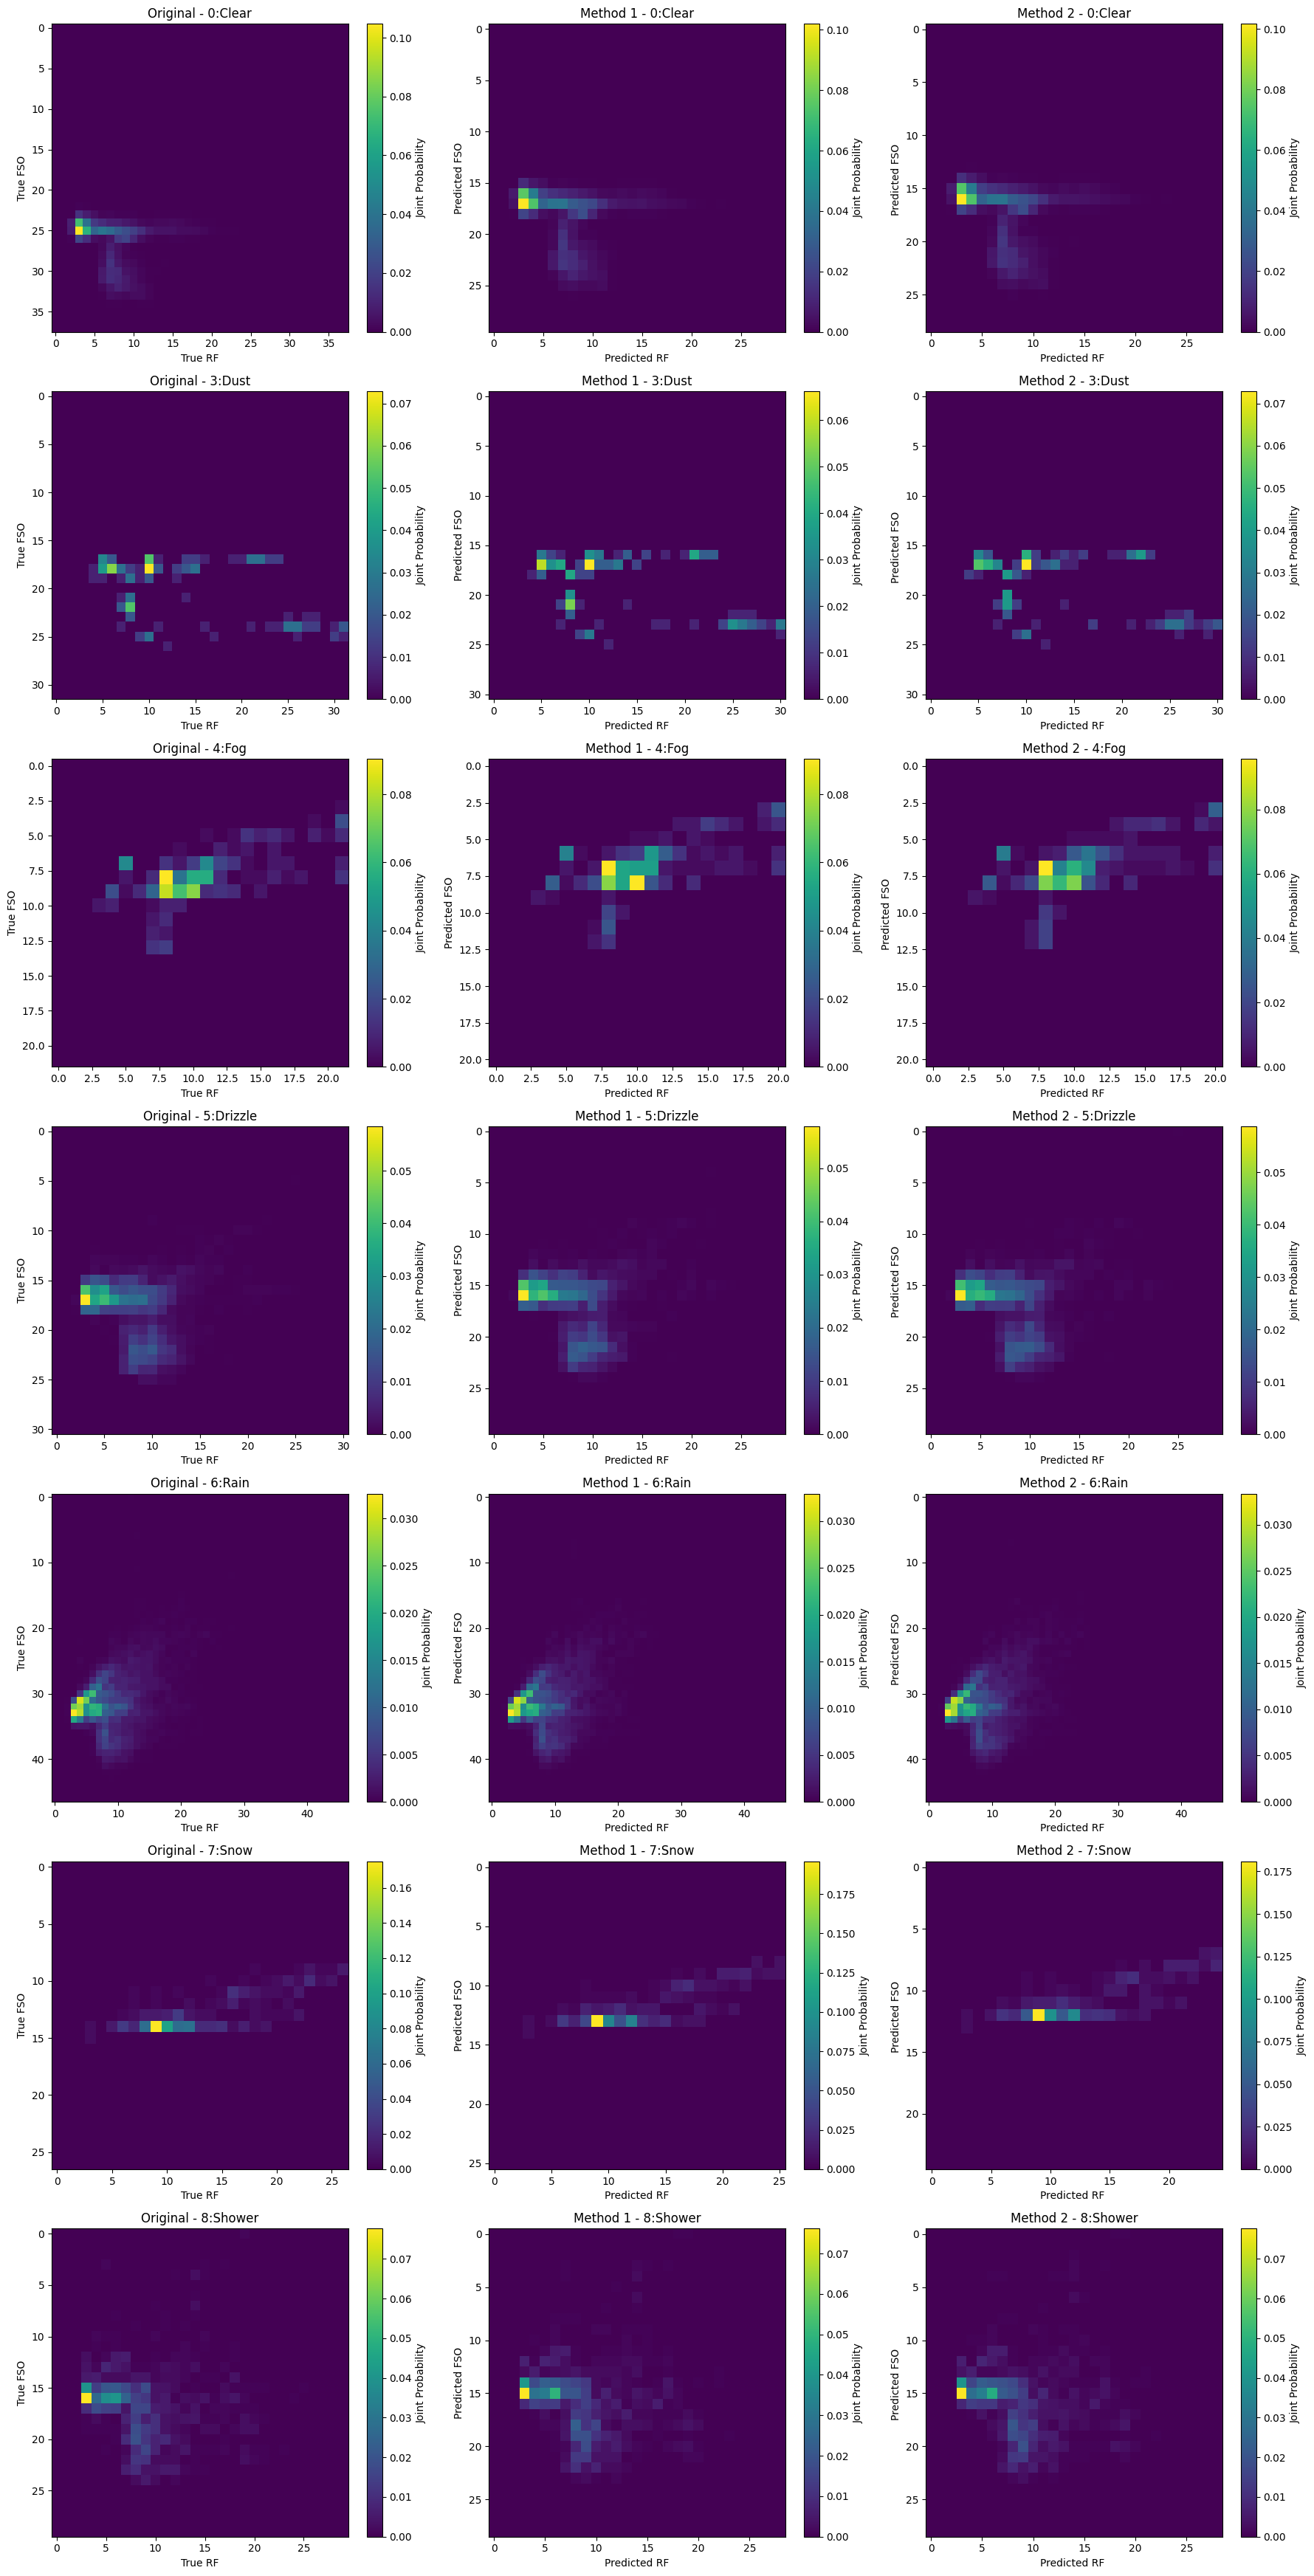

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def setting_bin(d1, d2, itvl=0.1):
    return np.arange(0, max(d1.max(), d2.max()) + itvl, itvl)

# ggenerate heatmaps for ooriginal, mmethod 1, and meethod 2 grouped by SYNOP code
def plotting_prob_heatmaps(data, synop_codes, interval=1):
    plt.figure(figsize=(18, len(synop_codes) * 5))  # Adjust figsize for better visibility
    plot_count = 1
    SYNOP_DATA_Grouped = data.groupby('SYNOPCode')

    for n, g in SYNOP_DATA_Grouped:
        synop_code_label = synop_codes[plot_count // 3] if plot_count // 3 < len(synop_codes) else 'All'

        # original
        DIG_ORI_RF = np.digitize(g["ORI_RF"], setting_bin(g["ORI_RF"], g["ORI_FSO"], interval))
        DIF_ORI_FSO = np.digitize(g["ORI_FSO"], setting_bin(g["ORI_RF"], g["ORI_FSO"], interval))
        ORI_JOINT_COUNT = np.histogram2d(DIG_ORI_RF, DIF_ORI_FSO, bins=[setting_bin(g["ORI_RF"], g["ORI_FSO"], interval)] * 2)[0]
        ORI_SUM =ORI_JOINT_COUNT.sum()
        ORI_JOINT_PROB = ORI_JOINT_COUNT / ORI_SUM

        plt.subplot(len(synop_codes), 3, plot_count)
        plt.imshow(np.flipud(ORI_JOINT_PROB), cmap="viridis", aspect='auto')
        plt.colorbar(label='Joint Probability')
        plt.title(f'Original - {synop_code_label}')
        plt.xlabel('True RF')
        plt.ylabel('True FSO')
        plot_count = plot_count+ 1

        # M 1
        M1_RF_DIG = np.digitize(g["RF_1st"], setting_bin(g["RF_1st"], g["FSO_2nd"], interval))
        M1_FSO_DIG = np.digitize(g["FSO_2nd"], setting_bin(g["RF_1st"], g["FSO_2nd"], interval))
        M1_JOINT_COUNT = np.histogram2d(M1_RF_DIG, M1_FSO_DIG, bins=[setting_bin(g["RF_1st"], g["FSO_2nd"], interval)] * 2)[0]
        M1_SUM =  M1_JOINT_COUNT.sum()
        M1_JOINT_PROB = M1_JOINT_COUNT / M1_SUM

        plt.subplot(len(synop_codes), 3, plot_count)
        plt.imshow(np.flipud(M1_JOINT_PROB), cmap="viridis", aspect='auto')
        plt.colorbar(label='Joint Probability')
        plt.title(f'Method 1 - {synop_code_label}')
        plt.xlabel('Predicted RF')
        plt.ylabel('Predicted FSO')
        plot_count = plot_count + 1

        # M 2
        M2_RF_DIG = np.digitize(g["RF_2nd"], setting_bin(g["RF_2nd"], g["FSO_1st"], interval))
        M2_FSO_DIG = np.digitize(g["FSO_1st"], setting_bin(g["RF_2nd"], g["FSO_1st"], interval))
        M2_JOINT_COUNT = np.histogram2d(M2_RF_DIG, M2_FSO_DIG, bins=[setting_bin(g["RF_2nd"], g["FSO_1st"], interval)] * 2)[0]
        M2_SUM = M2_JOINT_COUNT.sum()
        M2_JOINT_PROB= M2_JOINT_COUNT / M2_SUM

        plt.subplot(len(synop_codes), 3, plot_count)
        plt.imshow(np.flipud(M2_JOINT_PROB), cmap="viridis", aspect='auto')
        plt.colorbar(label='Joint Probability')
        plt.title(f'Method 2 - {synop_code_label}')
        plt.xlabel('Predicted RF ')
        plt.ylabel('Predicted FSO ')
        plot_count = plot_count + 1

    plt.tight_layout()
    plt.show()

s_codes = ['0:Clear', '3:Dust', '4:Fog', '5:Drizzle', '6:Rain', '7:Snow', '8:Shower']
plotting_prob_heatmaps(store_RF_FSO_train, s_codes)



In [ ]:
"""
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr

def calculating_metrics(data):
    f_results = {
        'SYNOPcode': [],
        'Pearson': [],
        'Mutual Information': []
    }

    grouped_data = data.groupby('SYNOPCode')
    for n, g in grouped_data:
        # Pearson Correlation
        CORR_pearson, P_VALUE_pearson = pearsonr(g['ORI_RF'], g['ORI_FSO'])

        # Mutual Information
        DIG_ORI_RF = np.digitize(g['ORI_RF'], bins=np.histogram_bin_edges(g['ORI_RF'], bins='auto'))
        DIF_ORI_FSO = np.digitize(g['ORI_FSO'], bins=np.histogram_bin_edges(g['ORI_FSO'], bins='auto'))
        MI = mutual_info_score(DIG_ORI_RF, DIF_ORI_FSO)

        f_results['SYNOPcode'].append(n)
        f_results['Pearson'].append(CORR_pearson)
        f_results['Mutual Information'].append(MI)

    # Printt Pearson and Mutual Information lists
    print(f"'Pearson': {f_results['Pearson']},")
    print(f"'Mutual Information': {f_results['Mutual Information']}")

    return f_results

final_results = calculating_metrics(store_RF_FSO_train)
"""

'\nimport numpy as np\nimport pandas as pd\nfrom sklearn.metrics import mutual_info_score\nfrom scipy.stats import pearsonr\n\ndef calculating_metrics(data):\n    f_results = {\n        \'SYNOPcode\': [],\n        \'Pearson\': [],\n        \'Mutual Information\': []\n    }\n\n    grouped_data = data.groupby(\'SYNOPCode\')\n    for n, g in grouped_data:\n        # Pearson Correlation\n        CORR_pearson, P_VALUE_pearson = pearsonr(g[\'ORI_RF\'], g[\'ORI_FSO\'])\n\n        # Mutual Information\n        DIG_ORI_RF = np.digitize(g[\'ORI_RF\'], bins=np.histogram_bin_edges(g[\'ORI_RF\'], bins=\'auto\'))\n        DIF_ORI_FSO = np.digitize(g[\'ORI_FSO\'], bins=np.histogram_bin_edges(g[\'ORI_FSO\'], bins=\'auto\'))\n        MI = mutual_info_score(DIG_ORI_RF, DIF_ORI_FSO)\n\n        f_results[\'SYNOPcode\'].append(n)\n        f_results[\'Pearson\'].append(CORR_pearson)\n        f_results[\'Mutual Information\'].append(MI)\n\n    # Printt Pearson and Mutual Information lists\n    print(f"\'Pear

In [ ]:
"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dictt = {
    'Weather_model': ['Clear Weather', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers'],
    'dt_Pearson': [-0.2664, -0.4245, 0.6111, -0.1607, 0.3458, 0.7927, -0.1703],
    'dt_Mutual Information': [0.4109, 0.5561, 0.7611, 0.4076, 0.4702, 0.5938, 0.4902]
}

df = pd.DataFrame(dictt)

thresh = {'High': 0.5, 'Moderate': 0.3, 'Low': 0.1}

fig, plt1 = plt.subplots()

# Plotting Pearson correlations
for i, (pearson_val, model) in enumerate(zip(df['dt_Pearson'], df['Weather_model'])):
    if pearson_val >= 0:
        label = 'Positive Corr. Coeff.'
        marker = '^'
    else:
        label = 'Negative Corr. Coeff.'
        marker = 's'

    if i == 0 or (pearson_val < 0 and i == df['dt_Pearson'][df['dt_Pearson'] < 0].index[0]) or \
       (pearson_val > 0 and i == df['dt_Pearson'][df['dt_Pearson'] > 0].index[0]):
        plt1.scatter(model, abs(pearson_val), color='blue', marker=marker, label=label)
    else:
        plt1.scatter(model, abs(pearson_val), color='blue', marker=marker)

# PLOTTING horizontal threshold lines
for label, value in thresh.items():
    plt1.axhline(y=value, color='gray', linestyle='--', linewidth=0.7)
    plt1.text(-0.5, value + 0.02, f'{label} Correlation', color='gray', fontsize=8)


plt1.set_ylim(0, 1)
plt1.set_ylabel('$r_{EO}$', color='blue')
plt1.spines['left'].set_color('blue')
plt1.tick_params(axis='y', colors='blue')

# Create a twin axis for Mutual Information
plt2 = plt1.twinx()
plt2.set_ylim(0, 1)
plt2.scatter(df['Weather_model'], df['dt_Mutual Information'], color='red', marker='D', label='Mutual Information')
plt2.set_ylabel('Mutual Information', color='red')
plt2.spines['right'].set_color('red')
plt2.tick_params(axis='y', colors='red')

handles, labels = plt1.get_legend_handles_labels()
handles2, labels2 = plt2.get_legend_handles_labels()
fig.legend(handles + handles2, labels + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt1.set_xticks(df.index)
plt1.set_xticklabels(df['Weather_model'], rotation=45, ha='right')

plt1.text(-2, 0.6, 'High correlation:\nr > 0.5', color='black', ha='right', fontsize=8)
plt1.text(-2, 0.4, 'Moderate correlation:\n0.3 < r < 0.5', color='black', ha='right', fontsize=8)
plt1.text(-2, 0.2, 'Low correlation:\nr < 0.3', color='black', ha='right', fontsize=8)

plt.subplots_adjust(left=0.25, right=0.85, bottom=0.3)
plt.title('Pearson Correlation Coefficients and Mutual Information by Weather Condition')
plt.xlabel('Weather Condition')
plt.tight_layout()
plt.show()

"""


"\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport numpy as np\n\ndictt = {\n    'Weather_model': ['Clear Weather', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers'],\n    'dt_Pearson': [-0.2664, -0.4245, 0.6111, -0.1607, 0.3458, 0.7927, -0.1703],\n    'dt_Mutual Information': [0.4109, 0.5561, 0.7611, 0.4076, 0.4702, 0.5938, 0.4902]\n}\n\ndf = pd.DataFrame(dictt)\n\nthresh = {'High': 0.5, 'Moderate': 0.3, 'Low': 0.1}\n\nfig, plt1 = plt.subplots()\n\n# Plotting Pearson correlations\nfor i, (pearson_val, model) in enumerate(zip(df['dt_Pearson'], df['Weather_model'])):\n    if pearson_val >= 0:\n        label = 'Positive Corr. Coeff.'\n        marker = '^'\n    else:\n        label = 'Negative Corr. Coeff.'\n        marker = 's'\n\n    if i == 0 or (pearson_val < 0 and i == df['dt_Pearson'][df['dt_Pearson'] < 0].index[0]) or        (pearson_val > 0 and i == df['dt_Pearson'][df['dt_Pearson'] > 0].index[0]):\n        plt1.scatter(model, abs(pearson_val), color='blue', 

In [ ]:
#### neww codes based on supervisor feedback

def calculate_four_correlation_plots():
    def calculate_metrics_per_group(data, name):
        f_results = {
            'SYNOPCode': [],
            f'Pearson ({name})': [],
            f'Mutual Information ({name})': []
        }

        grouped_data = data.groupby("SYNOPCode")

        for n, g in grouped_data:
            # Pearson Correlation
            CORR_pearson, P_VALUE_pearson = pearsonr(g['ORI_RF'], g['ORI_FSO'])

            # Mutual Information
            DIG_ORI_RF = np.digitize(g['ORI_RF'], bins=np.histogram_bin_edges(g['ORI_RF'], bins='auto'))
            DIF_ORI_FSO = np.digitize(g['ORI_FSO'], bins=np.histogram_bin_edges(g['ORI_FSO'], bins='auto'))
            MI = mutual_info_score(DIG_ORI_RF, DIF_ORI_FSO)

            f_results['SYNOPCode'].append(n)
            f_results[f'Pearson ({name})'].append(CORR_pearson)
            f_results[f'Mutual Information ({name})'].append(MI)

        return pd.DataFrame(f_results)

    # tesest Data
    test_data = STORE_test_RF_FSO.copy()
    if "SYNOPCode" not in test_data.columns:
        test_data["SYNOPCode"] = ORI_X_TEST["SYNOPCode"]

    # ggeneric Model
    generic_model_data = pd.DataFrame({
        'ORI_RF': RF_pred_y_val_M1,
        'ORI_FSO': ORI_X_VAL["FSO_Att"],
        'SYNOPCode': ORI_X_VAL["SYNOPCode"]
    })

    # hhybrid m 1
    hybrid1_data = pd.DataFrame({
        'ORI_RF': RF_pred_y_test_M1,
        'ORI_FSO': M1_FSO_Y_test_PRED,
        'SYNOPCode': ORI_X_TEST["SYNOPCode"]
    })

    # hhybrid m 2
    hybrid2_data = pd.DataFrame({
        'ORI_RF': M2_RF_PRED_Y_test,
        'ORI_FSO': M2_FSO_PRED_Y_test,
        'SYNOPCode': ORI_X_TEST["SYNOPCode"]
    })

    # calculatingg metrics for each method
    test_results = calculate_metrics_per_group(test_data, "Test Data")
    generic_results = calculate_metrics_per_group(generic_model_data, "Generic Model")
    hybrid1_results = calculate_metrics_per_group(hybrid1_data, "Hybrid Method 1")
    hybrid2_results = calculate_metrics_per_group(hybrid2_data, "Hybrid Method 2")

    final_results = test_results.merge(generic_results, on="SYNOPCode", how="outer")
    final_results = final_results.merge(hybrid1_results, on="SYNOPCode", how="outer")
    final_results = final_results.merge(hybrid2_results, on="SYNOPCode", how="outer")

    return final_results


# calculating and extracting results into THE LISTS
final_results = calculate_four_correlation_plots()

test_data_pearson = final_results[f'Pearson (Test Data)'].tolist()
test_data_mutual_information = final_results[f'Mutual Information (Test Data)'].tolist()

generic_results_pearson = final_results[f'Pearson (Generic Model)'].tolist()
generic_results_mutual_information = final_results[f'Mutual Information (Generic Model)'].tolist()

hybrid1_results_pearson = final_results[f'Pearson (Hybrid Method 1)'].tolist()
hybrid1_results_mutual_information = final_results[f'Mutual Information (Hybrid Method 1)'].tolist()

hybrid2_results_pearson = final_results[f'Pearson (Hybrid Method 2)'].tolist()
hybrid2_results_mutual_information = final_results[f'Mutual Information (Hybrid Method 2)'].tolist()

# pprinting results
print("test_data_pearson =", test_data_pearson)
print("test_data_mutual_information =", test_data_mutual_information)

print("generic_results_pearson =", generic_results_pearson)
print("generic_results_mutual_information =", generic_results_mutual_information)

print("hybrid1_results_pearson =", hybrid1_results_pearson)
print("hybrid1_results_mutual_information =", hybrid1_results_mutual_information)

print("hybrid2_results_pearson =", hybrid2_results_pearson)
print("hybrid2_results_mutual_information =", hybrid2_results_mutual_information)




test_data_pearson = [-0.2701255398341148, -0.5245523748448742, 0.38537023329616116, -0.08058155704877844, 0.34302541903319284, 0.8351493367952353, -0.18238412653162842]
test_data_mutual_information = [0.45315358893409013, 0.9755327099020328, 0.6458429393689877, 0.4144253272280058, 0.5129042608708645, 0.8649327187222715, 0.5400104767359017]
generic_results_pearson = [-0.280017853459062, -0.33032655070276246, 0.5825837647535512, -0.2885730370094246, 0.3654798582751941, 0.8685785362368512, -0.30226250746007804]
generic_results_mutual_information = [0.440794555871981, 0.7146213101161756, 0.7330188846790695, 0.3933407164010156, 0.5230321948679282, 0.6639257573513475, 0.5688693294188243]
hybrid1_results_pearson = [-0.2959358993993234, -0.5407614259838637, 0.41149453423361615, -0.09154629546208719, 0.3619235788762767, 0.8541032983155304, -0.24466987924300285]
hybrid1_results_mutual_information = [0.47308216812289505, 1.0893096789558299, 0.7208968215839182, 0.5052006610446182, 0.54066406284388

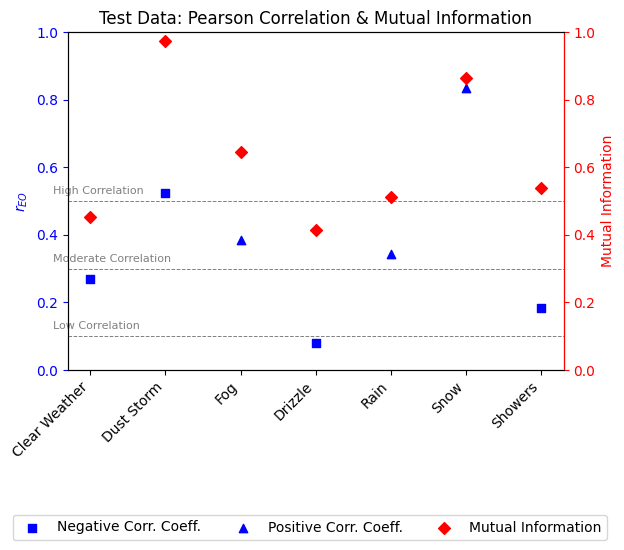

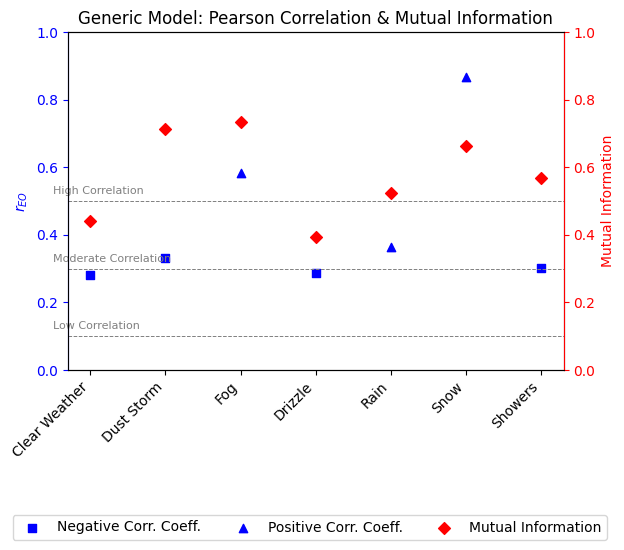

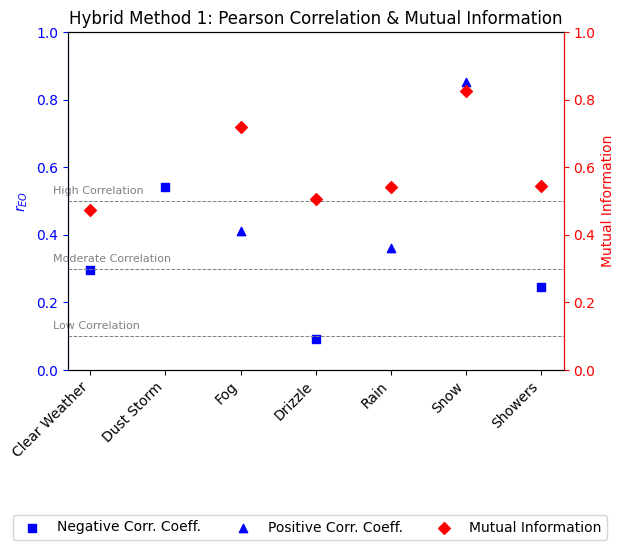

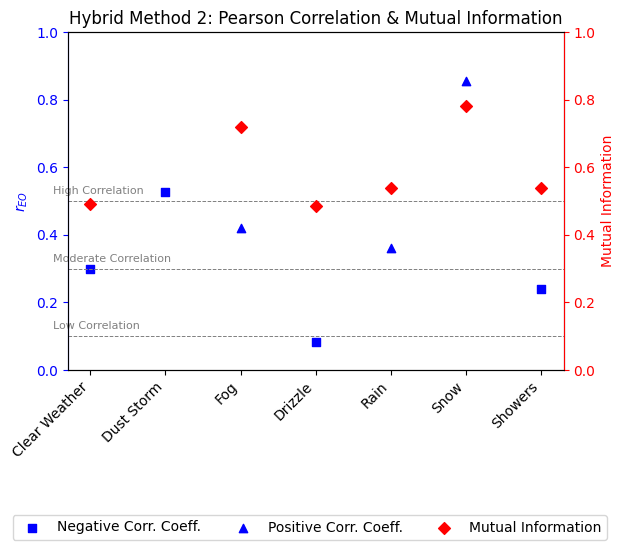

In [ ]:
##### neww codes based on supervisor feedback

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# tthresholds
thresh = {'High': 0.5, 'Moderate': 0.3, 'Low': 0.1}

def plot_correlation(data, title, pearson_key, mi_key):
    fig, plt1 = plt.subplots()

    # plottt Pearson correlations
    for i, (pearson_val, model) in enumerate(zip(data[pearson_key], data['Weather_model'])):
        if pearson_val >= 0:
            label = 'Positive Corr. Coeff.'
            marker = '^'
        else:
            label = 'Negative Corr. Coeff.'
            marker = 's'

        if i == 0 or (pearson_val < 0 and i == data[pearson_key][data[pearson_key] < 0].index[0]) or  (pearson_val > 0 and i == data[pearson_key][data[pearson_key] > 0].index[0]):
            plt1.scatter(model, abs(pearson_val), color='blue', marker=marker, label=label)
        else:
            plt1.scatter(model, abs(pearson_val), color='blue', marker=marker)

    # tyhreshold lines
    for label, value in thresh.items():
        plt1.axhline(y=value, color='gray', linestyle='--', linewidth=0.7)
        plt1.text(-0.5, value + 0.02, f'{label} Correlation', color='gray', fontsize=8)

    plt1.set_ylim(0, 1)
    plt1.set_ylabel('$r_{EO}$', color='blue')
    plt1.spines['left'].set_color('blue')
    plt1.tick_params(axis='y', colors='blue')

    # plot Mutual Information
    plt2 = plt1.twinx()
    plt2.set_ylim(0, 1)
    plt2.scatter(data['Weather_model'], data[mi_key], color='red', marker='D', label='Mutual Information')
    plt2.set_ylabel('Mutual Information', color='red')
    plt2.spines['right'].set_color('red')
    plt2.tick_params(axis='y', colors='red')

    h1, l1 = plt1.get_legend_handles_labels()
    h2, l2 = plt2.get_legend_handles_labels()
    fig.legend(h1 + h2, l1 + l2, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt1.set_xticks(data.index)
    plt1.set_xticklabels(data['Weather_model'], rotation=45, ha='right')

    plt.subplots_adjust(left=0.25, right=0.85, bottom=0.3)
    plt.title(title)
    plt.xlabel('Weather Condition')
    plt.tight_layout()
    plt.show()



test_data_pearson = [-0.2701255398341148, -0.5245523748448742, 0.38537023329616116, -0.08058155704877844, 0.34302541903319284, 0.8351493367952353, -0.18238412653162842]
test_data_mutual_information = [0.45315358893409013, 0.9755327099020328, 0.6458429393689877, 0.4144253272280058, 0.5129042608708645, 0.8649327187222715, 0.5400104767359017]
generic_results_pearson = [-0.280017853459062, -0.33032655070276246, 0.5825837647535512, -0.2885730370094246, 0.3654798582751941, 0.8685785362368512, -0.30226250746007804]
generic_results_mutual_information = [0.440794555871981, 0.7146213101161756, 0.7330188846790695, 0.3933407164010156, 0.5230321948679282, 0.6639257573513475, 0.5688693294188243]
hybrid1_results_pearson = [-0.2959358993993234, -0.5407614259838637, 0.41149453423361615, -0.09154629546208719, 0.3619235788762767, 0.8541032983155304, -0.24466987924300285]
hybrid1_results_mutual_information = [0.47308216812289505, 1.0893096789558299, 0.7208968215839182, 0.5052006610446182, 0.5406640628438819, 0.826663759651389, 0.5458614003829404]
hybrid2_results_pearson = [-0.2982271336965956, -0.5266681998938414, 0.42154398556020184, -0.08344268335896798, 0.36222405932503526, 0.8546626485392429, -0.24056963131266698]
hybrid2_results_mutual_information = [0.4916921504451654, 1.1004960753728792, 0.7190119567257227, 0.48701642255320554, 0.5390089833747833, 0.7826625868221019, 0.539345368495864]


test_data = {
    'Weather_model': ['Clear Weather', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers'],
    'Pearson': test_data_pearson,
    'Mutual Information': test_data_mutual_information
}

generic_model_data = {
    'Weather_model': ['Clear Weather', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers'],
    'Pearson': generic_results_pearson,
    'Mutual Information': generic_results_mutual_information
}

hybrid1_model_data = {
    'Weather_model': ['Clear Weather', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers'],
    'Pearson': hybrid1_results_pearson,
    'Mutual Information': hybrid1_results_mutual_information
}

hybrid2_model_data = {
    'Weather_model': ['Clear Weather', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers'],
    'Pearson': hybrid2_results_pearson,
    'Mutual Information': hybrid2_results_mutual_information
}

test_df = pd.DataFrame(test_data)
generic_df = pd.DataFrame(generic_model_data)
hybrid1_df = pd.DataFrame(hybrid1_model_data)
hybrid2_df = pd.DataFrame(hybrid2_model_data)

# plottingg the 4 graphs
plot_correlation(test_df, "Test Data: Pearson Correlation & Mutual Information", 'Pearson', 'Mutual Information')
plot_correlation(generic_df, "Generic Model: Pearson Correlation & Mutual Information", 'Pearson', 'Mutual Information')
plot_correlation(hybrid1_df, "Hybrid Method 1: Pearson Correlation & Mutual Information", 'Pearson', 'Mutual Information')
plot_correlation(hybrid2_df, "Hybrid Method 2: Pearson Correlation & Mutual Information", 'Pearson', 'Mutual Information')



In [ ]:
RF_Specific_RMSE_List= [0.3716406999834535, 0.4676322776603015, 0.433952153259994, 0.7109831439376549, 0.928169223758514, 0.2910006735030931, 1.3841845490382685]
RF_Specific_R2_List= [0.9787899056003636, 0.9810460794489206, 0.9186381587538568, 0.9406658190156798, 0.9471627856520616, 0.9582428817135822, 0.8222926050420747]
FSO_Specific_RMSE_List= [0.838693257860523, 2.2381638196151794, 0.7604381386582356, 1.0738290568464084, 0.90988295535555, 0.8083115567975064, 0.9651334531367992]
FSO_Specific_R2_List= [0.9429438447461106, 0.9470113616353576, 0.9591413837722028, 0.9123125818433796, 0.9568901037975568, 0.975717416130994, 0.929432336573282]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

def metrics_calculate(model, X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, use_oob=True):
    PRED_Y_TRAIN = model.predict(X_TRAIN)
    PRED_Y_VAL = model.predict(X_VAL)

    RMSE_TRAIN = np.sqrt(mean_squared_error(Y_TRAIN, PRED_Y_TRAIN))
    RMSE_VAL = np.sqrt(mean_squared_error(Y_VAL, PRED_Y_VAL))
    R2_TRAIN = r2_score(Y_TRAIN, PRED_Y_TRAIN)
    R2_VAL = r2_score(Y_VAL, PRED_Y_VAL)

    R2_OOB = model.oob_score_ if use_oob and hasattr(model, "oob_score_") else None

    return RMSE_TRAIN, R2_TRAIN, RMSE_VAL, R2_VAL, R2_OOB

def splitting_data(data, col_target, col_drop=None, test_size= 0.2, SPLIT_val_test=True, random_state=42):
    if col_drop:
        data = data.drop(columns=col_drop)

    X = data.drop(columns=[col_target])
    y = data[col_target]

    XTRAIN, TEMP_X, YTRAIN, TEMP_Y = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if SPLIT_val_test:
        XVAL, XTEST, YVAL, YTEST = train_test_split(TEMP_X, TEMP_Y, test_size=0.5, random_state=random_state)
    else:
        XVAL =  TEMP_X
        YVAL = TEMP_Y
        XTEST = None
        YTEST = None

    return XTRAIN, XVAL, XTEST, YTRAIN, YVAL, YTEST

data = pd.read_csv("RFLFSODataFull.csv")

FSO_X_train, FSO_X_val, FSO_X_test, FSO_Y_train, FSO_Y_val, FSO_Y_test = splitting_data(data, "FSO_Att", col_drop=["Frequency", 'RFL_Att'])
RF_X_train, RF_X_val, RF_X_test, RF_Y_train, RF_Y_val, RF_Y_test = splitting_data(data, "RFL_Att", col_drop=['FSO_Att'])

RF_extract_imp = ['Frequency', 'Time', 'RelativeHumidity', 'SYNOPCode', "Visibility", "RainIntensityMin", "ParticulateMax", "Temperature", "RainIntensityMax", "Distance", "RainIntensity", "AbsoluteHumidity", "AbsoluteHumidityMax"]
FSO_extract_imp = ['Time', 'ParticulateMax', 'TemperatureDifference', 'TemperatureMax', 'RelativeHumidity', 'Particulate', 'TemperatureMin', "VisibilityMin", "AbsoluteHumidity", "VisibilityMax", "ParticulateMin", "Temperature", "Visibility", "Distance"]

RF_Specific_RMSE_List = [0.3719674212466868, 0.4598125729844288, 0.4343137673718009, 0.7097480315701898, 0.9262770090305884, 0.2878570137865562, 1.3665897900414583]
RF_Specific_R2_List = [0.978752596258649, 0.9816746710030718, 0.918502503943519, 0.94087178937362, 0.9473779995182882, 0.9591402069181904, 0.8267816690004541]
FSO_Specific_RMSE_List = [0.8385794110189987, 2.253391061861144, 0.752964506632996, 1.072245469111326, 0.9098389544411, 0.7899531205286532, 0.9520980565209533]
FSO_Specific_R2_List = [0.9429593336561108, 0.9462878975355083, 0.9599405591104848, 0.912571018378133, 0.9568942731887476, 0.9768079061845064, 0.931325681789853]

RF_Generic_RMSE_List = []
RF_Generic_R2_List = []
FSO_Generic_RMSE_List = []
FSO_Generic_R2_List = []

SYNOP = [0, 3, 4, 5, 6, 7, 8]
for i in SYNOP:
    RF_SY_X_train = RF_X_train[RF_X_train['SYNOPCode'] == i]
    RF_SY_Y_train = RF_Y_train[RF_X_train['SYNOPCode'] == i]
    RF_SY_X_val = RF_X_val[RF_X_val['SYNOPCode'] == i]
    RF_SY_Y_val = RF_Y_val[RF_X_val['SYNOPCode'] == i]

    FSO_SY_X_train = FSO_X_train[FSO_X_train['SYNOPCode'] == i]
    FSO_SY_Y_train = FSO_Y_train[FSO_X_train['SYNOPCode'] == i]
    FSO_SY_X_val = FSO_X_val[FSO_X_val['SYNOPCode'] == i]
    FSO_SY_Y_val = FSO_Y_val[FSO_X_val['SYNOPCode'] == i]

    # Fit the RF and FSO models for this SYNOP code
    RF_model = RandomForestRegressor(n_estimators=130, max_depth= 30, min_samples_leaf=1, random_state=42,
                                     min_samples_split=4, oob_score=True, n_jobs=-1)

    FSO_model = RandomForestRegressor(n_estimators=140, max_depth= 30, min_samples_leaf=1, random_state=42,
                                      min_samples_split=4, oob_score=True, n_jobs=-1)

    RF_model.fit(RF_SY_X_train[RF_extract_imp], RF_SY_Y_train)
    FSO_model.fit(FSO_SY_X_train[FSO_extract_imp], FSO_SY_Y_train)


    RMSE_TRAIN, R2_TRAIN, RMSE_VAL, R2_VAL, oob_r2 = metrics_calculate(RF_model, RF_SY_X_train[RF_extract_imp], RF_SY_Y_train, RF_SY_X_val[RF_extract_imp], RF_SY_Y_val, use_oob=True)
    RF_Generic_RMSE_List.append(RMSE_VAL)
    RF_Generic_R2_List.append(R2_VAL)

    RMSE_TRAIN, R2_TRAIN, RMSE_VAL, R2_VAL, oob_r2 = metrics_calculate(FSO_model, FSO_SY_X_train[FSO_extract_imp], FSO_SY_Y_train, FSO_SY_X_val[FSO_extract_imp], FSO_SY_Y_val, use_oob=True)
    FSO_Generic_RMSE_List.append(RMSE_VAL)
    FSO_Generic_R2_List.append(R2_VAL)



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

FSO_Hybrid_RMSE_List = []
FSO_Hybrid_R2_List = []
RF_Hybrid_RMSE_List = []
RF_Hybrid_R2_List = []

data = pd.read_csv("RFLFSODataFull.csv")

codes = [0, 3, 4, 5, 6, 7, 8]

FSO_H_model = RandomForestRegressor(
    n_estimators= 140, max_depth=30, min_samples_leaf=1, random_state=42,
    min_samples_split=2, oob_score=True, n_jobs=-1
)

RFO_H_model = RandomForestRegressor(
    n_estimators= 140, max_depth=30, min_samples_leaf=1, random_state=42,
    min_samples_split=2, oob_score=True, n_jobs=-1
)


for i in codes:

    RF_ORI_X_train, RF_ORI_X_val, RF_Y_train, RF_Y_val = train_test_split(data, data["RFL_Att"], test_size=0.2, random_state=42)
    FSO_ORI_X_train, FSO_ORI_X_val, FSO_Y_train, FSO_Y_val = train_test_split(data, data["FSO_Att"], test_size=0.2, random_state=42)

    RF_X_train_SYNOP = RF_ORI_X_train[RF_ORI_X_train['SYNOPCode'] == i]
    RF_Y_train_SYNOP = RF_Y_train[RF_ORI_X_train['SYNOPCode'] == i]
    RF_X_val_SYNOP = RF_ORI_X_val[RF_ORI_X_val['SYNOPCode'] == i]
    RF_Y_val_SYNOP = RF_Y_val[RF_ORI_X_val['SYNOPCode'] == i]

    FSO_X_train_SYNOP = FSO_ORI_X_train[FSO_ORI_X_train['SYNOPCode'] == i]
    FSO_Y_train_SYNOP = FSO_Y_train[FSO_ORI_X_train['SYNOPCode'] == i]
    FSO_X_val_SYNOP = FSO_ORI_X_val[FSO_ORI_X_val['SYNOPCode'] == i]
    FSO_Y_val_SYNOP = FSO_Y_val[FSO_ORI_X_val['SYNOPCode'] == i]

    #  uzing hybrid Model for FSO Prediction (RF to FSO)
    RF_FEATURES_X_train = RF_X_train_SYNOP.drop(columns=["RFL_Att", "FSO_Att"])
    RF_FEATURES_X_val = RF_X_val_SYNOP.drop(columns=["RFL_Att", "FSO_Att"])

    RF_M1_model = RFO_H_model.fit(RF_FEATURES_X_train, RF_Y_train_SYNOP)
    RF_Y_train_PRED = RF_M1_model.predict(RF_FEATURES_X_train)
    RF_Y_test_PRED = RF_M1_model.predict(RF_FEATURES_X_val)

    FSO_FEATURES_X_train = RF_FEATURES_X_train.assign(RF_Att_pred=RF_Y_train_PRED)
    FSO_FEATURES_X_val = RF_FEATURES_X_val.assign(RF_Att_pred=RF_Y_test_PRED)

    # ttrain FSO model and make predictions
    FSO_M1_model = FSO_H_model.fit(FSO_FEATURES_X_train, FSO_Y_train_SYNOP)
    FSO_Y_test_PRED = FSO_M1_model.predict(FSO_FEATURES_X_val)

    # ccalculate  (Method 1)
    FSO_M1_RMSE = np.sqrt(mean_squared_error(FSO_Y_val_SYNOP, FSO_Y_test_PRED))
    FSO_M1_R2 = r2_score(FSO_Y_val_SYNOP, FSO_Y_test_PRED)
    FSO_Hybrid_RMSE_List.append(FSO_M1_RMSE)
    FSO_Hybrid_R2_List.append(FSO_M1_R2)

    # uzing hybrid Model for RFL Prediction (FSO to RF)
    FSO_FEATURES_X_train_B = FSO_X_train_SYNOP.drop(columns=["RFL_Att", "FSO_Att"])
    FSO_FEATURES_X_val_B = FSO_X_val_SYNOP.drop(columns=["RFL_Att", "FSO_Att"])

    FSO_M2_model = FSO_H_model.fit(FSO_FEATURES_X_train_B, FSO_Y_train_SYNOP)
    FSO_Y_train_PRED_m2 = FSO_M2_model.predict(FSO_FEATURES_X_train_B)
    FSO_Y_test_PRED_m2 = FSO_M2_model.predict(FSO_FEATURES_X_val_B)

    RF_FEATURES_X_train_wFSO = FSO_FEATURES_X_train_B.assign(FSO_Att_pred=FSO_Y_train_PRED_m2)
    RF_FEATURES_X_val_wFSO = FSO_FEATURES_X_val_B.assign(FSO_Att_pred=FSO_Y_test_PRED_m2)

    ## TRAINN
    RF_M2_model = RFO_H_model.fit(RF_FEATURES_X_train_wFSO, RF_Y_train_SYNOP)
    RF_Y_test_PRED_m2 = RF_M2_model.predict(RF_FEATURES_X_val_wFSO)

    # Calculate  (Method 2)
    RF_M2_RMSE = np.sqrt(mean_squared_error(RF_Y_val_SYNOP, RF_Y_test_PRED_m2))
    RF_M2_R2 = r2_score(RF_Y_val_SYNOP, RF_Y_test_PRED_m2)
    RF_Hybrid_RMSE_List.append(RF_M2_RMSE)
    RF_Hybrid_R2_List.append(RF_M2_R2)

"""
# results
print("FSO_Hybrid_RMSE_List:", FSO_Hybrid_RMSE_List)
print("FSO_Hybrid_R2_List:", FSO_Hybrid_R2_List)
print("RF_Hybrid_RMSE_List:", RF_Hybrid_RMSE_List)
print("RF_Hybrid_R2_List:", RF_Hybrid_R2_List)
"""

'\n# results\nprint("FSO_Hybrid_RMSE_List:", FSO_Hybrid_RMSE_List)\nprint("FSO_Hybrid_R2_List:", FSO_Hybrid_R2_List)\nprint("RF_Hybrid_RMSE_List:", RF_Hybrid_RMSE_List)\nprint("RF_Hybrid_R2_List:", RF_Hybrid_R2_List)\n'

In [ ]:
# results
print("FSO_Hybrid_RMSE_List M1:", FSO_Hybrid_RMSE_List)
print("FSO_Hybrid_R2_List M1:", FSO_Hybrid_R2_List)
print("RF_Hybrid_RMSE_List M2:", RF_Hybrid_RMSE_List)
print("RF_Hybrid_R2_List M2:", RF_Hybrid_R2_List)


FSO_Hybrid_RMSE_List M1: [0.8598842119273166, 1.6104203424685948, 0.6855282629719122, 0.9315239426220407, 0.8968523174873798, 0.849833575797778, 0.7590152424423858]
FSO_Hybrid_R2_List M1: [0.9406976160420139, 0.967715879845461, 0.9679009187026777, 0.9304701524677332, 0.9556982385673928, 0.9799146788491258, 0.9605812740298914]
RF_Hybrid_RMSE_List M2: [0.4984515377058425, 0.4675470736297583, 0.26642762135075687, 0.5439850119716828, 0.7411276230691624, 0.4402341776543712, 0.88018775647938]
RF_Hybrid_R2_List M2: [0.9628326019086577, 0.9782331754850252, 0.9724175373403767, 0.9638813000649519, 0.9664771396892086, 0.9417306202908995, 0.9053140271092907]


In [ ]:
print("RF_Generic_RMSE_List", RF_Generic_RMSE_List)
print("RF_Generic_R2_List",RF_Generic_R2_List)

print("FSO_Generic_RMSE_List",FSO_Generic_RMSE_List)
print("FSO_Generic_R2_List",FSO_Generic_R2_List)

FSO_Hybrid_RMSE_List_M1 = FSO_Hybrid_RMSE_List
FSO_Hybrid_R2_List_M1 = FSO_Hybrid_R2_List

RF_Hybrid_RMSE_List_M2 =  RF_Hybrid_RMSE_List
RF_Hybrid_R2_List_M2 = RF_Hybrid_R2_List

print("FSO_Hybrid_RMSE_List M1:", FSO_Hybrid_RMSE_List_M1)
print("FSO_Hybrid_R2_List M1:", FSO_Hybrid_R2_List_M1)


print("RF_Hybrid_RMSE_List M2:", RF_Hybrid_RMSE_List_M2)
print("RF_Hybrid_R2_List M2:", RF_Hybrid_R2_List_M2)




RF_Generic_RMSE_List [0.5131762562844293, 0.4689160653516631, 0.2784831936031972, 0.4702667916727792, 0.8124767180865168, 0.43502596067356186, 0.8876680319921845]
RF_Generic_R2_List [0.9615437458089662, 0.9779780788514115, 0.9710296914116517, 0.9728526822307998, 0.9599318535191531, 0.946270071995542, 0.9061473736246096]
FSO_Generic_RMSE_List [0.8349678916391805, 1.9491643386885589, 0.7945574392034987, 0.8529548308596125, 0.8202511211379526, 0.9688190789427676, 0.6869733457917913]
FSO_Generic_R2_List [0.9443709202235612, 0.946888934084112, 0.9695728557906438, 0.9322860591312739, 0.9636173248096987, 0.976228361558165, 0.9652008280478175]
FSO_Hybrid_RMSE_List M1: [0.8598842119273166, 1.6104203424685948, 0.6855282629719122, 0.9315239426220407, 0.8968523174873798, 0.849833575797778, 0.7590152424423858]
FSO_Hybrid_R2_List M1: [0.9406976160420139, 0.967715879845461, 0.9679009187026777, 0.9304701524677332, 0.9556982385673928, 0.9799146788491258, 0.9605812740298914]
RF_Hybrid_RMSE_List M2: [0.4

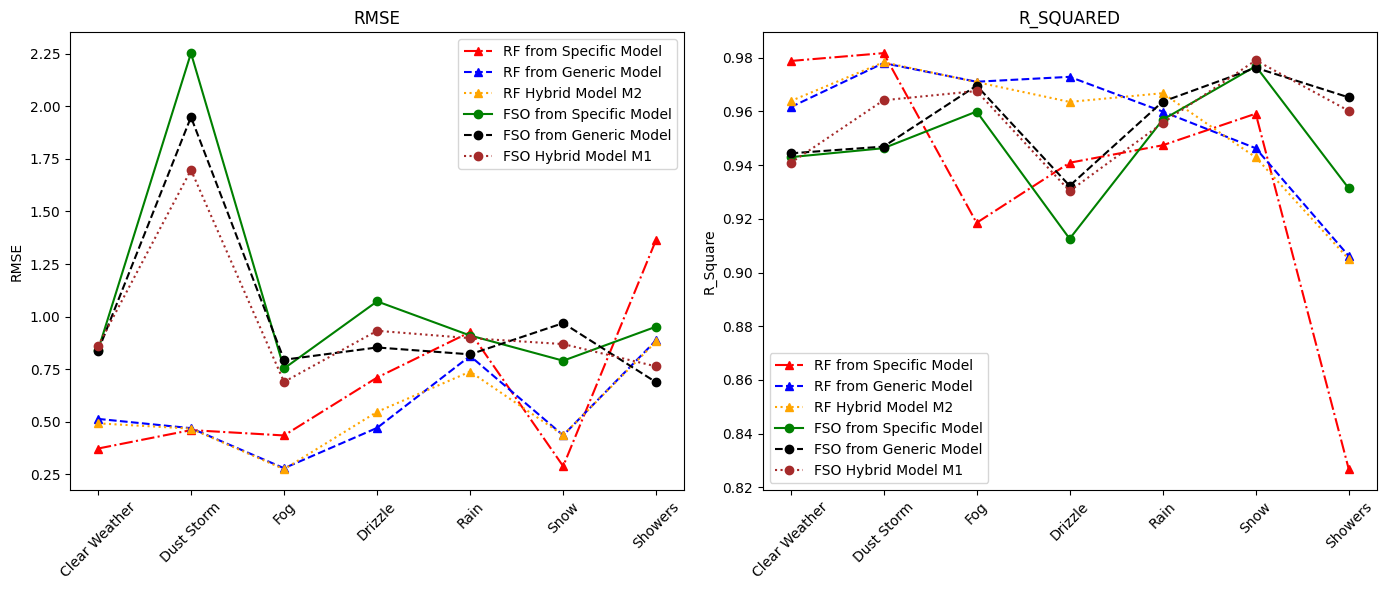

In [ ]:

RF_Generic_RMSE_List = [0.5131762562844293, 0.46891606535166297, 0.2784831936031977, 0.47026679167277924, 0.8124767180865167, 0.4350259606735612, 0.887668031992184]
RF_Generic_R2_List=  [0.9615437458089662, 0.9779780788514115, 0.9710296914116516, 0.9728526822307998, 0.9599318535191531, 0.9462700719955423, 0.9061473736246097]
FSO_Generic_RMSE_List = [0.8349678916391806, 1.9491643386885593, 0.7945574392034991, 0.8529548308596125, 0.8202511211379527, 0.968819078942767, 0.6869733457917914]
FSO_Generic_R2_List = [0.9443709202235612, 0.946888934084112, 0.9695728557906437, 0.9322860591312739, 0.9636173248096987, 0.976228361558165, 0.9652008280478175]
FSO_Hybrid_RMSE_List_M1 = [0.8594347095316975, 1.6974193416326546, 0.689148741848432, 0.9323808934315964, 0.8971688230576692, 0.8690958919350277, 0.7626979982855294]
FSO_Hybrid_R2_List_M1 = [0.9407596001928058, 0.9641335203240733, 0.9675609737796862, 0.9303421663511158, 0.9556669642356392, 0.978993852851245, 0.9601978252718197]
RF_Hybrid_RMSE_List_M2 = [0.4918801914865231, 0.4669309034037398, 0.27368237695553604, 0.5466929995601739, 0.73798799117925, 0.4358808103626014, 0.8817198689231123]
RF_Hybrid_R2_List_M2 = [0.9638061363530839, 0.978290509739471, 0.97089495935, 0.963520803219368, 0.9667605632303125, 0.9428773453491631, 0.9049841070097908]

RF_Specific_RMSE_List = [0.3719674212466868, 0.4598125729844288, 0.4343137673718009, 0.7097480315701898, 0.9262770090305884, 0.2878570137865562, 1.3665897900414583]
RF_Specific_R2_List = [0.978752596258649, 0.9816746710030718, 0.918502503943519, 0.94087178937362, 0.9473779995182882, 0.9591402069181904, 0.8267816690004541]
FSO_Specific_RMSE_List = [0.8385794110189987, 2.253391061861144, 0.752964506632996, 1.072245469111326, 0.9098389544411, 0.7899531205286532, 0.9520980565209533]
FSO_Specific_R2_List = [0.9429593336561108, 0.9462878975355083, 0.9599405591104848, 0.912571018378133, 0.9568942731887476, 0.9768079061845064, 0.931325681789853]


import matplotlib.pyplot as plt

list_of_weather = ["Clear Weather", "Dust Storm", "Fog", "Drizzle", "Rain", "Snow", "Showers"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RMSE Plot
axes[0].plot(list_of_weather, RF_Specific_RMSE_List, 'r^-.', label='RF from Specific Model')
axes[0].plot(list_of_weather, RF_Generic_RMSE_List, 'b^--', label='RF from Generic Model')
axes[0].plot(list_of_weather, RF_Hybrid_RMSE_List_M2, 'orange', marker='^', linestyle=':', label='RF Hybrid Model M2')
axes[0].plot(list_of_weather, FSO_Specific_RMSE_List, 'go-', label='FSO from Specific Model')
axes[0].plot(list_of_weather, FSO_Generic_RMSE_List, 'ko--', label='FSO from Generic Model')
axes[0].plot(list_of_weather, FSO_Hybrid_RMSE_List_M1, color='brown', marker='o', linestyle=':', label='FSO Hybrid Model M1')
axes[0].set_title('RMSE')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# R2 Plot
axes[1].plot(list_of_weather, RF_Specific_R2_List, 'r^-.', label='RF from Specific Model')
axes[1].plot(list_of_weather, RF_Generic_R2_List, 'b^--', label='RF from Generic Model')
axes[1].plot(list_of_weather, RF_Hybrid_R2_List_M2, 'orange', marker='^', linestyle=':', label='RF Hybrid Model M2')
axes[1].plot(list_of_weather, FSO_Specific_R2_List, 'go-', label='FSO from Specific Model')
axes[1].plot(list_of_weather, FSO_Generic_R2_List, 'ko--', label='FSO from Generic Model')
axes[1].plot(list_of_weather, FSO_Hybrid_R2_List_M1, color='brown', marker='o', linestyle=':', label='FSO Hybrid Model M1')
axes[1].set_title('R_SQUARED')
axes[1].set_ylabel('R_Square')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()


fig.tight_layout()
plt.show()


<Figure size 1400x600 with 0 Axes>

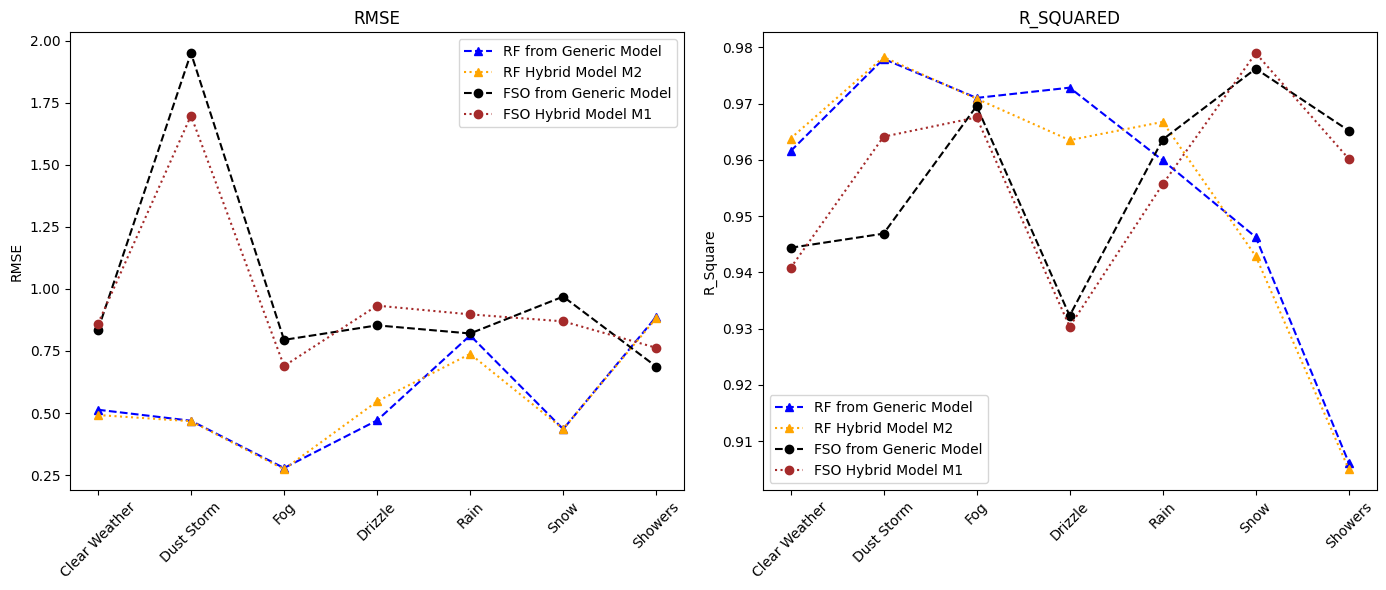

In [ ]:
import matplotlib.pyplot as plt

list_of_weather = ["Clear Weather", "Dust Storm", "Fog", "Drizzle", "Rain", "Snow", "Showers"]

RF_Generic_RMSE_List = [0.5131762562844293, 0.46891606535166297, 0.2784831936031977, 0.47026679167277924, 0.8124767180865167, 0.4350259606735612, 0.887668031992184]
RF_Generic_R2_List=  [0.9615437458089662, 0.9779780788514115, 0.9710296914116516, 0.9728526822307998, 0.9599318535191531, 0.9462700719955423, 0.9061473736246097]
FSO_Generic_RMSE_List = [0.8349678916391806, 1.9491643386885593, 0.7945574392034991, 0.8529548308596125, 0.8202511211379527, 0.968819078942767, 0.6869733457917914]
FSO_Generic_R2_List = [0.9443709202235612, 0.946888934084112, 0.9695728557906437, 0.9322860591312739, 0.9636173248096987, 0.976228361558165, 0.9652008280478175]


FSO_Hybrid_RMSE_List_M1 = [0.8594347095316975, 1.6974193416326546, 0.689148741848432, 0.9323808934315964, 0.8971688230576692, 0.8690958919350277, 0.7626979982855294]
FSO_Hybrid_R2_List_M1 = [0.9407596001928058, 0.9641335203240733, 0.9675609737796862, 0.9303421663511158, 0.9556669642356392, 0.978993852851245, 0.9601978252718197]
RF_Hybrid_RMSE_List_M2 = [0.4918801914865231, 0.4669309034037398, 0.27368237695553604, 0.5466929995601739, 0.73798799117925, 0.4358808103626014, 0.8817198689231123]
RF_Hybrid_R2_List_M2 = [0.9638061363530839, 0.978290509739471, 0.97089495935, 0.963520803219368, 0.9667605632303125, 0.9428773453491631, 0.9049841070097908]

plt.figure(figsize=(14, 6))

import matplotlib.pyplot as plt

# ccreate a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# RMSE Plot
axs[0].plot(list_of_weather, RF_Generic_RMSE_List, 'b^--', label='RF from Generic Model')
axs[0].plot(list_of_weather, RF_Hybrid_RMSE_List_M2, color='orange', marker='^', linestyle=':', label='RF Hybrid Model M2')
axs[0].plot(list_of_weather, FSO_Generic_RMSE_List, 'ko--', label='FSO from Generic Model')
axs[0].plot(list_of_weather, FSO_Hybrid_RMSE_List_M1, color='brown', marker='o', linestyle=':', label='FSO Hybrid Model M1')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE')
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend()

# R2 Plot
axs[1].plot(list_of_weather, RF_Generic_R2_List, 'b^--', label='RF from Generic Model')
axs[1].plot(list_of_weather, RF_Hybrid_R2_List_M2, color='orange', marker='^', linestyle=':', label='RF Hybrid Model M2')
axs[1].plot(list_of_weather, FSO_Generic_R2_List, 'ko--', label='FSO from Generic Model')
axs[1].plot(list_of_weather, FSO_Hybrid_R2_List_M1, color='brown', marker='o', linestyle=':', label='FSO Hybrid Model M1')
axs[1].set_ylabel('R_Square')
axs[1].set_title('R_SQUARED')
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend()

fig.tight_layout()
plt.show()



In [ ]:
import pandas as pd

# eata for RMSE rounded to 2dpp
rmse_data = {
    'Condition': ['Clear', 'Dust', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers'],
    'generic FSO': [round(x, 2) for x in FSO_Generic_RMSE_List],
    'hybrid FSO(M1)': [round(x, 2) for x in FSO_Hybrid_RMSE_List_M1],
    'generic RF': [round(x, 2) for x in RF_Generic_RMSE_List],
    'hybrid RF(M2)': [round(x, 2) for x in RF_Hybrid_RMSE_List_M2]
}

# data for R2  in  percentage and rounded to 2dpp
r2_data = {
    'Condition': ['Clear', 'Dust', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers'],
    'generic FSO': [round(x * 100, 2) for x in FSO_Generic_R2_List],
    'hybrid FSO(M1)': [round(x * 100, 2) for x in FSO_Hybrid_R2_List_M1],
    'generic RF': [round(x * 100, 2) for x in RF_Generic_R2_List],
    'hybrid RF(M2)': [round(x * 100, 2) for x in RF_Hybrid_R2_List_M2]
}

rmse_df = pd.DataFrame(rmse_data)
r2_df = pd.DataFrame(r2_data)

print("RMSE Table (Rounded to 2 Decimal Places):")
print(rmse_df)

print("\nR² Table (Converted to Percentage and Rounded to 2 Decimal Places):")
print(r2_df)


RMSE Table (Rounded to 2 Decimal Places):
  Condition  generic FSO  hybrid FSO(M1)  generic RF  hybrid RF(M2)
0     Clear         0.83            0.86        0.51           0.49
1      Dust         1.95            1.70        0.47           0.47
2       Fog         0.79            0.69        0.28           0.27
3   Drizzle         0.85            0.93        0.47           0.55
4      Rain         0.82            0.90        0.81           0.74
5      Snow         0.97            0.87        0.44           0.44
6   Showers         0.69            0.76        0.89           0.88

R² Table (Converted to Percentage and Rounded to 2 Decimal Places):
  Condition  generic FSO  hybrid FSO(M1)  generic RF  hybrid RF(M2)
0     Clear        94.44           94.08       96.15          96.38
1      Dust        94.69           96.41       97.80          97.83
2       Fog        96.96           96.76       97.10          97.09
3   Drizzle        93.23           93.03       97.29          96.35
4    

In [ ]:
import pandas as pd

# eata for RMSE rounded to 2dpp
rmse_data = {
    'Condition': ['Clear', 'Dust', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers'],
    'generic FSO': [round(x, 2) for x in FSO_Generic_RMSE_List],
    'specific FSO': [round(x, 2) for x in FSO_Specific_RMSE_List],
    'hybrid FSO(M1)': [round(x, 2) for x in FSO_Hybrid_RMSE_List_M1],
    'generic RF': [round(x, 2) for x in RF_Generic_RMSE_List],
    'specific RF': [round(x, 2) for x in RF_Specific_RMSE_List],
    'hybrid RF(M2)': [round(x, 2) for x in RF_Hybrid_RMSE_List_M2]
}

# # data for R2  in  percentage and rounded to 2dpp
r2_data = {
    'Condition': ['Clear', 'Dust', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers'],
    'generic FSO': [round(x * 100, 2) for x in FSO_Generic_R2_List],
    'specific FSO': [round(x * 100, 2) for x in FSO_Specific_R2_List],
    'hybrid FSO(M1)': [round(x * 100, 2) for x in FSO_Hybrid_R2_List_M1],
    'generic RF': [round(x * 100, 2) for x in RF_Generic_R2_List],
    'specific RF': [round(x * 100, 2) for x in RF_Specific_R2_List],
    'hybrid RF(M2)': [round(x * 100, 2) for x in RF_Hybrid_R2_List_M2]
}

rmse_df = pd.DataFrame(rmse_data)
r2_df = pd.DataFrame(r2_data)

print("RMSE Table (Rounded to 2 Decimal Places):")
print(rmse_df)

print("\nR² Table (Converted to Percentage and Rounded to 2 Decimal Places):")
print(r2_df)


RMSE Table (Rounded to 2 Decimal Places):
  Condition  generic FSO  specific FSO  hybrid FSO(M1)  generic RF  \
0     Clear         0.83          0.84            0.86        0.51   
1      Dust         1.95          2.25            1.70        0.47   
2       Fog         0.79          0.75            0.69        0.28   
3   Drizzle         0.85          1.07            0.93        0.47   
4      Rain         0.82          0.91            0.90        0.81   
5      Snow         0.97          0.79            0.87        0.44   
6   Showers         0.69          0.95            0.76        0.89   

   specific RF  hybrid RF(M2)  
0         0.37           0.49  
1         0.46           0.47  
2         0.43           0.27  
3         0.71           0.55  
4         0.93           0.74  
5         0.29           0.44  
6         1.37           0.88  

R² Table (Converted to Percentage and Rounded to 2 Decimal Places):
  Condition  generic FSO  specific FSO  hybrid FSO(M1)  generic RF  \
0 